# ASSIGNMENT 2: DYNAMICS ON NETWORKS - THRESHOLDS AND SPREADING
## Unified Simulation Framework

**Course:** Model Based Decision-making (5404MBDM6Y)  
**Student:** 10205071  
**Date:** November 20, 2025

### Description
This notebook integrates graph ingestion (YouTube), Hub-and-Spoke sampling, Linear Threshold Model (LTM) simulation with 5 threshold distributions, and high-fidelity visualization into a single pipeline.

"**Note:** This notebook is adapted from and builds on methods and code in the following notebooks from week 3-dynamics on networks : \n",
  "- `Network_Topology_Spreading_Experiment.ipynb`\n",
  "- `Network_Robustness_Experiment.ipynb`\n",
  "- `Granovetter_Threshold_Experiments.ipynb`\n" by MH Lees publisched at https://github.com/mhlees/Model-Based-Decisions-Code

**Dependencies:** `networkx`, `matplotlib`, `pandas`, `numpy`, `scipy`, `gzip`

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
import random
import os
import sys
import time
import gzip
import seaborn as sns
import matplotlib.colors as mcolors
from collections import defaultdict

In [2]:
# ==========================================
# CONFIGURATION & CONSTANTS
# ==========================================

# I/O Settings
INPUT_FILE = "com-youtube.ungraph.txt.gz"
OUTPUT_DIR = "simulation_outputs"
RESULTS_CSV = "monte_carlo_results.csv"
BC_FILE = "sampled_bc_exact.csv"

# Simulation Parameters
N_TARGET_SUBGRAPH = 2000    # Target size for the sampled subgraph
SEED_FRACTION = 0.01        # 1% of nodes to seed active
NUM_SIMULATIONS = 10        # R=10 (Default per assignment hint, validated by stats check)
MAX_STEPS = 50              # Guard clause for convergence

# Statistical Constants for Rigor Check
CONFIDENCE_LEVEL = 0.99 
Z_SCORE = st.norm.ppf(1 - (1 - CONFIDENCE_LEVEL) / 2) 
PRECISION_EPSILON = 0.01 

# Reproducibility
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

# Ensure output directory exists
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## Module 1: Graph Ingestion & Sampling

In [3]:
def load_network_data(filepath="datasets\com-youtube.ungraph.txt.gz",
                      data_dir=".",
                      youtube_url="https://snap.stanford.edu/data/com-Youtube.ungraph.txt.gz",
                      force_download=False,
                      max_rows=None,
                      dtype_nodes=np.int32):
    """
    Robust loader: try local (data_dir, datasets/), optional download, parse with pandas,
    clean (drop NA/self-loops/dupes), build NetworkX graph and return LCC.
    Falls back to a Barabasi-Albert surrogate graph on any failure (preserved).
    """
    from io import BytesIO
    try:
        import requests
    except Exception:
        requests = None

    start = time.time()
    candidates = [
        os.path.join(data_dir, filepath),
        os.path.join(data_dir, os.path.basename(filepath)),
        os.path.join("datasets", filepath),
        os.path.join("datasets", os.path.basename(filepath)),
        filepath,
        os.path.basename(filepath),
    ]
    # if user passed .gz, also consider uncompressed
    if filepath.endswith(".gz"):
        ungz = filepath[:-3]
        candidates.extend([os.path.join(data_dir, ungz), os.path.join("datasets", ungz), ungz, os.path.basename(ungz)])
    # keep order, remove duplicates
    seen = set(); candidates = [p for p in candidates if not (p in seen or seen.add(p))]

    found = None
    for p in candidates:
        if os.path.exists(p) and not force_download:
            found = p; break

    df = None
    read_kwargs = dict(sep="\t", comment="#", names=["start_node", "end_node"],
                       dtype={"start_node": dtype_nodes, "end_node": dtype_nodes},
                       header=None, engine="c")

    if found:
        print(f"[INFO] Loading local file: {found}")
        try:
            if str(found).endswith(".gz"):
                df = pd.read_csv(found, compression="gzip", **read_kwargs, nrows=max_rows)
            else:
                df = pd.read_csv(found, **read_kwargs, nrows=max_rows)
        except Exception as e:
            print(f"[WARN] Failed to parse local file ({e}). Will fallback to surrogate or download.")
            df = None

    if df is None and requests is not None and youtube_url:
        try:
            print(f"[INFO] Attempting download from {youtube_url} ...")
            r = requests.get(youtube_url, timeout=90)
            r.raise_for_status()
            buf = BytesIO(r.content)
            df = pd.read_csv(buf, compression="gzip", **read_kwargs, nrows=max_rows)
            print("[INFO] Downloaded and parsed dataset.")
        except Exception as e:
            print(f"[WARN] Download/parse failed: {e}")
            df = None

    if df is None or df.shape[0] == 0:
        print("[WARN] Edge-list not available or empty. Generating Barabasi-Albert surrogate graph.")
        G = nx.barabasi_albert_graph(n=5000, m=3, seed=GLOBAL_SEED)
        elapsed = time.time() - start
        print(f"[INFO] Surrogate BA graph created in {elapsed:.2f}s: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
        return G

    # defensive cleaning
    try:
        df = df.dropna()
        df = df[df.start_node != df.end_node]
        df = df.drop_duplicates()
        df.start_node = df.start_node.astype(dtype_nodes, copy=False)
        df.end_node = df.end_node.astype(dtype_nodes, copy=False)
    except Exception as e:
        print(f"[WARN] Cleaning failed ({e}). Proceeding with best-effort df.")

    if df.shape[0] == 0:
        print("[WARN] No valid edges after cleaning. Generating Barabasi-Albert surrogate.")
        G = nx.barabasi_albert_graph(n=5000, m=3, seed=GLOBAL_SEED)
        return G

    try:
        G = nx.from_pandas_edgelist(df, "start_node", "end_node", create_using=nx.Graph())
    except Exception as e:
        print(f"[WARN] Failed to build graph from dataframe ({e}). Generating surrogate BA graph.")
        return nx.barabasi_albert_graph(n=5000, m=3, seed=GLOBAL_SEED)

    # extract LCC
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    elapsed = time.time() - start
    print(f"[INFO] LCC Loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges (load time {elapsed:.2f}s)")
    return G

def hub_and_spoke_sampling(G_full, N_target=2000):
    """
    Creates a Hub-and-Spoke sample by selecting top hubs and their immediate neighbors.
    This preserves the Scale-Free core-periphery structure better than random sampling.
    """
    if G_full.number_of_nodes() <= N_target:
        return G_full

    print(f"[INFO] Executing Hub-and-Spoke Sampling (Target N={N_target})...")
    
    degree_map = dict(G_full.degree())
    sorted_hubs = sorted(degree_map.keys(), key=degree_map.get, reverse=True)
    
    # Heuristic: Select top 5% as initial hubs
    k_H = max(10, int(len(G_full) * 0.05)) 
    hubs = set(sorted_hubs[:k_H])
    
    # Include Spokes (Neighbors of the Hubs)
    nodes_to_keep = set(hubs)
    for node in hubs:
        nodes_to_keep.update(G_full.neighbors(node))
        if len(nodes_to_keep) >= N_target * 1.5: # Optimization break
            break
            
    # If we have too many, trim by degree; if too few, keep all
    if len(nodes_to_keep) > N_target:
        # Prioritize keeping high degree nodes within the neighborhood
        subgraph_degrees = {n: degree_map[n] for n in nodes_to_keep}
        sorted_selection = sorted(subgraph_degrees, key=subgraph_degrees.get, reverse=True)
        nodes_to_keep = set(sorted_selection[:N_target])
        
    G_sampled = G_full.subgraph(nodes_to_keep).copy()
    
    # Tag nodes for visualization
    nx.set_node_attributes(G_sampled, {n: 'Hub' if n in hubs else 'Spoke' for n in G_sampled.nodes()}, 'role')
    
    print(f"[INFO] Sample Generated: {G_sampled.number_of_nodes()} nodes, {G_sampled.number_of_edges()} edges.")
    return G_sampled

## Module 2: Centrality & Seeding

In [4]:
def precompute_centrality(G):
    """
    Calculates Betweenness Centrality on the sampled graph.
    Saves to CSV to demonstrate data persistence.
    Returns the map for simulation usage.
    """
    csv_path = os.path.join(OUTPUT_DIR, BC_FILE)
    print("[INFO] Calculating EXACT Betweenness Centrality (this may take a moment)...")
    start_t = time.time()
    
    bc_map = nx.betweenness_centrality(G, normalized=True, seed=GLOBAL_SEED)
    
    # Save to CSV
    df = pd.DataFrame(bc_map.items(), columns=['Node', 'Betweenness'])
    df = df.sort_values(by='Betweenness', ascending=False)
    df.to_csv(csv_path, index=False)
    
    print(f"[INFO] Centrality calculated in {time.time()-start_t:.2f}s. Saved to {csv_path}")
    return bc_map

def get_seeds(G, strategy, fraction, bc_map=None):
    """Selects seeds based on the specified strategy."""
    N = G.number_of_nodes()
    num_seeds = max(1, int(N * fraction))
    
    nodes = list(G.nodes())
    
    if strategy == 'Random':
        return random.sample(nodes, num_seeds)
    
    elif strategy == 'Degree':
        # Recalculate degree for the specific subgraph
        degree_map = dict(G.degree())
        sorted_nodes = sorted(degree_map.keys(), key=degree_map.get, reverse=True)
        return sorted_nodes[:num_seeds]
        
    elif strategy == 'Betweenness':
        if bc_map is None:
            # Fallback if not precomputed
            bc_map = nx.betweenness_centrality(G, normalized=True)
        # Sort using the precomputed map
        sorted_nodes = sorted(bc_map.keys(), key=lambda x: bc_map.get(x, 0), reverse=True)
        return sorted_nodes[:num_seeds]
        
    return []

## Module 3: Threshold Dynamics (LTM)

In [5]:
def get_thresholds(G, scenario_key):
    """
    Generates threshold values based on distributions.
    Supported keys:
      - 'Fixed_0.2'   : all thresholds = 0.2
      - 'Uniform'     : Uniform(0,1)
      - 'Beta_Low'    : Beta(2,5)
      - 'Beta_Mid'    : Beta(2,2)
      - 'Beta_High'   : Beta(5,2)
      - 'Normal'      : Normal(phi_mean, phi_std) clipped to [0,1]  (uses GLOBAL defaults)
      - 'Constant_0.4': constant 0.4
    Any unknown key falls back to constant 0.4.
    """
    # Optional parameters (use global defaults if available)
    phi_mean = globals().get('PHI_MEAN', 0.3)
    phi_std = globals().get('PHI_STD', 0.1)

    if scenario_key == 'Fixed_0.2':
        return {n: 0.2 for n in G.nodes()}

    if scenario_key == 'Uniform':
        return {n: float(np.random.uniform(0, 1)) for n in G.nodes()}

    if scenario_key == 'Beta_Low':
        return {n: float(np.random.beta(2, 5)) for n in G.nodes()}

    if scenario_key == 'Beta_Mid':
        return {n: float(np.random.beta(2, 2)) for n in G.nodes()}

    if scenario_key == 'Beta_High':
        return {n: float(np.random.beta(5, 2)) for n in G.nodes()}

    if scenario_key in ('Normal', 'normal'):
        vals = np.clip(np.random.normal(phi_mean, phi_std, len(G)), 0.0, 1.0)
        return {n: float(vals[i]) for i, n in enumerate(G.nodes())}

    if scenario_key in ('Constant_0.4', 'constant_0.4', 'Const_0.4'):
        return {n: 0.4 for n in G.nodes()}

    # Fallback: constant 0.4 (safe conservative default)
    return {n: 0.4 for n in G.nodes()}

def run_threshold_simulation(G, seeds, thresholds):
    """
    Executes one run of the Linear Threshold Model.
    Returns adoption history and final state stats.
    """
    # Initialization
    active_set = set(seeds)
    history = [len(active_set) / len(G)]
    
    # Pre-compute neighbors to speed up inner loop
    adj = {n: set(G.neighbors(n)) for n in G.nodes()}
    degrees = {n: len(adj[n]) for n in G.nodes()}
    
    for step in range(MAX_STEPS):
        newly_active = set()
        
        # Optimization: Check only inactive nodes connected to active ones
        # For density, iterating all inactive is safer for correctness
        inactive_nodes = [n for n in G.nodes() if n not in active_set]
        
        if not inactive_nodes:
            break
            
        for node in inactive_nodes:
            deg = degrees[node]
            if deg == 0: continue
            
            # Count active neighbors
            active_neighbors = len([nbr for nbr in adj[node] if nbr in active_set])
            influence = active_neighbors / deg
            
            if influence >= thresholds[node]:
                newly_active.add(node)
        
        if newly_active:
            active_set.update(newly_active)
            history.append(len(active_set) / len(G))
        else:
            # Convergence reached
            history.extend([history[-1]] * (MAX_STEPS - step - 1))
            break
            
    return history, len(active_set)

## Module 4: Execution & Stats

In [6]:
def calculate_statistical_rigor(pilot_variances):
    """
    Calculates R_req for statistical rigor based on pilot data variance.
    Formula: R_req >= (Z * s0 / epsilon)^2
    Returns the maximum recommended runs across scenarios.
    """
    print("\n" + "="*40)
    print("STATISTICAL RIGOR CHECK")
    print("="*40)

    max_r_req = 0
    per_scenario = {}

    for scenario, s0 in pilot_variances.items():
        if s0 == 0:
            per_scenario[scenario] = 0.0
            continue
        r_req = (Z_SCORE * s0 / PRECISION_EPSILON) ** 2
        per_scenario[scenario] = r_req
        print(f"Scenario [{scenario}]: StdDev={s0:.4f} -> R_req >= {r_req:.1f}")
        max_r_req = max(max_r_req, r_req)

    print(f"\n[DECISION] Recommended Runs for {CONFIDENCE_LEVEL*100}% Confidence: {int(np.ceil(max_r_req))}")
    print(f"[ACTION] Using configured NUM_SIMULATIONS = {NUM_SIMULATIONS}")
    return max_r_req, per_scenario


def adaptive_execute_experiment_suite(G, bc_map, pilot_runs=10, max_total_runs=500, max_wall_time_seconds=600):
    """
    Run pilot_runs first (defaults to 10). Compute variance and recommended R_req,
    then run additional trials up to min(ceil(R_req), max_total_runs), but also
    cap additional runs based on estimated runtime derived from the pilot and
    available CPU cores (os.cpu_count()) using max_wall_time_seconds budget.
    Returns combined DataFrame of timeseries. Also saves aggregated teacher-style
    summary and pivot tables to OUTPUT_DIR for reporting.
    """
    strategies = ['Random', 'Degree', 'Betweenness']
    threshold_scenarios =   ['Fixed_0.2', 'Uniform', 'Beta_Low', 'Beta_Mid', 'Beta_High', 'Normal', 'Constant_0.4']

    if G is None:
        raise ValueError("Graph G must be provided")

    # seed-budget fallback used in aggregation when needed
    B = max(1, int(G.number_of_nodes() * SEED_FRACTION))

    results_data = []
    pilot_tracker = defaultdict(list)

    total_pilot_units = pilot_runs * len(threshold_scenarios) * len(strategies)
    print(f"\n[INFO] Starting PILOT: {pilot_runs} runs per setting -> {total_pilot_units} simulation units...")
    pilot_start = time.time()
    unit_counter = 0

    # --- PILOT PHASE ---
    for thresh_key in threshold_scenarios:
        for trial in range(pilot_runs):
            trial_seed = GLOBAL_SEED + (abs(hash(thresh_key)) % 1000) + trial * 1009
            random.seed(trial_seed); np.random.seed(trial_seed)
            thresholds = get_thresholds(G, thresh_key)

            for strat in strategies:
                seeds = get_seeds(G, strat, SEED_FRACTION, bc_map)
                curve, _ = run_threshold_simulation(G, seeds, thresholds)
                final_frac = float(curve[-1])
                pilot_tracker[f"{strat}_{thresh_key}"].append(final_frac)

                arr = np.array(curve)
                changes = np.where(np.diff(arr) != 0)[0]
                time_to_converge = int(changes[-1] + 1) if len(changes) else 0

                for t, val in enumerate(curve):
                    results_data.append({
                        'Trial': trial,
                        'Strategy': strat,
                        'Threshold_Dist': thresh_key,
                        'Step': int(t),
                        'Adoption_Fraction': float(val),
                        'Final_Fraction': final_frac,
                        'TimeToConverge': time_to_converge,
                        'SeedsCount': len(seeds)
                    })

                unit_counter += 1
                if unit_counter % 50 == 0:
                    print(f" -> Completed {unit_counter}/{total_pilot_units} pilot simulation units...")

    pilot_elapsed = time.time() - pilot_start
    time_per_unit = pilot_elapsed / max(1, total_pilot_units)
    cores = os.cpu_count() or 1

    # Compute pilot variances and recommended runs
    variances = {k: np.std(v, ddof=0) for k, v in pilot_tracker.items()}
    max_r_req, per_scenario = calculate_statistical_rigor(variances)

    # Decide target trials-per-setting (R_req rounded up), but respect max_total_runs cap
    recommended_total_per_setting = int(np.ceil(max_r_req))
    target_total_per_setting = max(pilot_runs, min(recommended_total_per_setting, max_total_runs))

    # Time-based cap: how many additional simulation-units can we do within max_wall_time_seconds
    # (we assume we could parallelize across 'cores' workers)
    max_additional_units_time = int((max_wall_time_seconds * cores) / max(1e-9, time_per_unit))
    # Convert unit-cap to trials-per-setting cap
    units_per_setting = len(threshold_scenarios) * len(strategies)
    additional_runs_time_cap = max(0, max_additional_units_time // units_per_setting - pilot_runs)
    # Final additional runs to execute (per setting)
    additional_runs_requested = max(0, target_total_per_setting - pilot_runs)
    additional_runs = min(additional_runs_requested, additional_runs_time_cap)

    print(f"\n[INFO] Pilot elapsed {pilot_elapsed:.1f}s -> ~{time_per_unit:.3f}s per simulation unit (cores={cores})")
    print(f"[INFO] Recommended trials-per-setting = {recommended_total_per_setting}, target (capped) = {target_total_per_setting}")
    print(f"[INFO] Time-budget allows ~{additional_runs_time_cap} additional trials-per-setting; executing {additional_runs} additional trials-per-setting.")

    if additional_runs <= 0:
        print("[INFO] No additional runs scheduled (time/cap reached). Proceeding to aggregation and return pilot results.")
        df_ts = pd.DataFrame(results_data)
        # perform aggregation & pivots (teacher-style) and save
        final_per_trial = df_ts.groupby(['Trial', 'Strategy', 'Threshold_Dist'], as_index=False).agg(
            Final_Fraction=('Final_Fraction', 'max'),
            TimeToConverge=('TimeToConverge', 'max'),
            SeedsCount=('SeedsCount', 'max')
        )

        agg = final_per_trial.groupby(['Strategy', 'Threshold_Dist'], as_index=False).agg(
            n_runs=('Final_Fraction', 'count'),
            FinalAdoption=('Final_Fraction', 'mean'),
            Final_STD=('Final_Fraction', 'std'),
            CascadeProb=('Final_Fraction', lambda x: np.mean(np.array(x) >= 0.5)),
            Time50=('TimeToConverge', 'mean'),
            Seeds=('SeedsCount', lambda x: int(x.mode().iloc[0]) if len(x) > 0 else B)
        )
        agg['Efficiency'] = agg['FinalAdoption'] / agg['Seeds'].replace(0, 1)

        os.makedirs(OUTPUT_DIR, exist_ok=True)
        agg_path = os.path.join(OUTPUT_DIR, "aggregated_summary_by_strategy_threshold_teacherstyle.csv")
        agg.to_csv(agg_path, index=False)
        print(f"[INFO] Saved aggregated teacher-style summary to {agg_path}")

        # pivots
        try:
            pivot_final = agg.pivot_table(index='Strategy', columns='Threshold_Dist', values='FinalAdoption', aggfunc='mean')
            pivot_final.to_csv(os.path.join(OUTPUT_DIR, "pivot_final_adoption.csv"))
            print(f"[INFO] Saved pivot_final_adoption.csv")
        except Exception:
            pass

        try:
            pivot_cascade = agg.pivot_table(index='Strategy', columns='Threshold_Dist', values='CascadeProb', aggfunc='mean')
            pivot_cascade.to_csv(os.path.join(OUTPUT_DIR, "pivot_cascade_prob.csv"))
            print(f"[INFO] Saved pivot_cascade_prob.csv")
        except Exception:
            pass

        try:
            pivot_eff = agg.pivot_table(index='Strategy', columns='Threshold_Dist', values='Efficiency', aggfunc='mean')
            pivot_eff.to_csv(os.path.join(OUTPUT_DIR, "pivot_efficiency.csv"))
            print(f"[INFO] Saved pivot_efficiency.csv")
        except Exception:
            pass

        det_path = os.path.join(OUTPUT_DIR, "detailed_per_trial_summary.csv")
        final_per_trial.to_csv(det_path, index=False)
        print(f"[INFO] Saved detailed per-trial summary to {det_path}")

        return df_ts

    # --- ADDITIONAL RUNS PHASE ---
    print(f"\n[INFO] Running additional {additional_runs} runs per setting (may take time)...")
    pbar2 = 0
    for extra in range(additional_runs):
        trial = pilot_runs + extra
        for thresh_key in threshold_scenarios:
            trial_seed = GLOBAL_SEED + (abs(hash(thresh_key)) % 1000) + trial * 1009
            random.seed(trial_seed); np.random.seed(trial_seed)
            thresholds = get_thresholds(G, thresh_key)

            for strat in strategies:
                seeds = get_seeds(G, strat, SEED_FRACTION, bc_map)
                curve, _ = run_threshold_simulation(G, seeds, thresholds)
                final_frac = float(curve[-1])

                arr = np.array(curve)
                changes = np.where(np.diff(arr) != 0)[0]
                time_to_converge = int(changes[-1] + 1) if len(changes) else 0

                for t, val in enumerate(curve):
                    results_data.append({
                        'Trial': trial,
                        'Strategy': strat,
                        'Threshold_Dist': thresh_key,
                        'Step': int(t),
                        'Adoption_Fraction': float(val),
                        'Final_Fraction': final_frac,
                        'TimeToConverge': time_to_converge,
                        'SeedsCount': len(seeds)
                    })

                pilot_tracker[f"{strat}_{thresh_key}"].append(final_frac)  # keep variance updated

                pbar2 += 1
                if pbar2 % 50 == 0:
                    total_add_units = additional_runs * len(threshold_scenarios) * len(strategies)
                    print(f" -> Completed {pbar2}/{total_add_units} additional simulation units...")

    # Final aggregation & save pivot tables
    df_ts = pd.DataFrame(results_data)

    final_per_trial = df_ts.groupby(['Trial', 'Strategy', 'Threshold_Dist'], as_index=False).agg(
        Final_Fraction=('Final_Fraction', 'max'),
        TimeToConverge=('TimeToConverge', 'max'),
        SeedsCount=('SeedsCount', 'max')
    )

    agg = final_per_trial.groupby(['Strategy', 'Threshold_Dist'], as_index=False).agg(
        n_runs=('Final_Fraction', 'count'),
        FinalAdoption=('Final_Fraction', 'mean'),
        Final_STD=('Final_Fraction', 'std'),
        CascadeProb=('Final_Fraction', lambda x: np.mean(np.array(x) >= 0.5)),
        Time50=('TimeToConverge', 'mean'),
        Seeds=('SeedsCount', lambda x: int(x.mode().iloc[0]) if len(x) > 0 else B)
    )
    agg['Efficiency'] = agg['FinalAdoption'] / agg['Seeds'].replace(0, 1)

    os.makedirs(OUTPUT_DIR, exist_ok=True)
    agg_path = os.path.join(OUTPUT_DIR, "aggregated_summary_by_strategy_threshold_teacherstyle.csv")
    agg.to_csv(agg_path, index=False)
    print(f"[INFO] Saved aggregated teacher-style summary to {agg_path}")

    # Pivot tables (Strategy x Threshold)
    try:
        pivot_final = agg.pivot_table(index='Strategy', columns='Threshold_Dist', values='FinalAdoption', aggfunc='mean')
        pivot_final.to_csv(os.path.join(OUTPUT_DIR, "pivot_final_adoption.csv"))
        print(f"[INFO] Saved pivot_final_adoption.csv")
    except Exception:
        pass

    try:
        pivot_cascade = agg.pivot_table(index='Strategy', columns='Threshold_Dist', values='CascadeProb', aggfunc='mean')
        pivot_cascade.to_csv(os.path.join(OUTPUT_DIR, "pivot_cascade_prob.csv"))
        print(f"[INFO] Saved pivot_cascade_prob.csv")
    except Exception:
        pass

    try:
        pivot_eff = agg.pivot_table(index='Strategy', columns='Threshold_Dist', values='Efficiency', aggfunc='mean')
        pivot_eff.to_csv(os.path.join(OUTPUT_DIR, "pivot_efficiency.csv"))
        print(f"[INFO] Saved pivot_efficiency.csv")
    except Exception:
        pass

    det_path = os.path.join(OUTPUT_DIR, "detailed_per_trial_summary.csv")
    final_per_trial.to_csv(det_path, index=False)
    print(f"[INFO] Saved detailed per-trial summary to {det_path}")

    # Final variance report
    final_variances = {k: np.std(v, ddof=0) for k, v in pilot_tracker.items()}
    print("\n[INFO] Final variance estimates after adaptive runs:")
    for k, v in final_variances.items():
        print(f"  {k}: std={v:.4f}")
    calculate_statistical_rigor(final_variances)

    return df_ts


# Thin wrapper to preserve call sites and provide automatic time-based capping
def execute_experiment_suite(G, bc_map, B=None):
    """
    Backwards-compatible entrypoint. Runs adaptive scheme:
      - pilot of NUM_SIMULATIONS (default 10)
      - compute required R_req and run additional trials up to time/cap limits
    Returns DataFrame of per-step timeseries (same as previous usage).
    """
    # Tunable caps (trials per setting)
    MAX_TOTAL_TRIALS_PER_SETTING = 500
    # Wall-time budget in seconds used to estimate feasible additional runs (default 10 minutes)
    MAX_WALL_TIME_SECONDS = 600

    return adaptive_execute_experiment_suite(G, bc_map,
                                            pilot_runs=NUM_SIMULATIONS,
                                            max_total_runs=MAX_TOTAL_TRIALS_PER_SETTING,
                                            max_wall_time_seconds=MAX_WALL_TIME_SECONDS)

## Module 5: Visualization

In [ ]:
def visualize_network_structure(G):
    """
    Visualizes the Hub-and-Spoke topology (full graph; no subsampling).
    - Uses Kamada-Kawai layout; falls back to spring_layout only if KK raises.
    - Hubs colored by degree (colormap), sized by degree (sqrt scale).
    - Spokes drawn faintly underneath.
    - Saves to OUTPUT_DIR and shows the figure.
    """
    if len(G) == 0:
        print("[WARN] Empty graph given; skipping plot.")
        return

    if len(G) > 3000:
        print("[WARN] Graph large; plotting full graph may be slow but will proceed.")

    print("\n[INFO] Generating Network Topology Plot (Kamada-Kawai primary, spring fallback)...")
    fig, ax = plt.subplots(figsize=(12, 12))

    # layout: prefer Kamada-Kawai, use spring only on failure
    try:
        pos = nx.kamada_kawai_layout(G)
    except Exception as e:
        print(f"[WARN] Kamada-Kawai layout failed ({e}). Falling back to spring_layout.")
        pos = nx.spring_layout(G, seed=GLOBAL_SEED)

    # attributes
    roles = nx.get_node_attributes(G, 'role')
    degrees = dict(G.degree())

    # fallback: infer hubs if no 'role' attribute
    if not roles:
        deg_sorted = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
        k = max(1, int(len(G) * 0.05))
        hubs = [n for n, _ in deg_sorted[:k]]
        spokes = [n for n in G.nodes() if n not in hubs]
    else:
        hubs = [n for n, r in roles.items() if r == 'Hub']
        spokes = [n for n in G.nodes() if n not in hubs]

    # size scaling (sqrt to reduce huge differences)
    max_deg = max(degrees.values()) if degrees else 1
    min_size, max_size = 40, 420
    hub_sizes = [min_size + (np.sqrt(degrees.get(n, 0)) / np.sqrt(max_deg)) * (max_size - min_size) for n in hubs]
    spoke_size = 28

    # color hubs by degree using a soft colormap
    import matplotlib.cm as cm
    cmap = cm.get_cmap("Reds")
    norm = plt.Normalize(vmin=min([degrees[n] for n in hubs]) if hubs else 0, vmax=max_deg)
    hub_colors = [cmap(norm(degrees.get(n, 0))) for n in hubs]
    spoke_color = "#4C72B0"  # muted blue

    # draw: edges first (faint), spokes next, then hubs on top
    nx.draw_networkx_edges(G, pos, alpha=0.06, edge_color="#888888", ax=ax, width=0.6)

    # draw spokes and set z-order on returned collection
    spokes_coll = nx.draw_networkx_nodes(
        G, pos,
        nodelist=spokes,
        node_size=spoke_size,
        node_color=spoke_color,
        alpha=0.55,
        linewidths=0.0,
        ax=ax,
        label="Spokes"
    )
    if hasattr(spokes_coll, "set_zorder"):
        spokes_coll.set_zorder(1)

    # draw hubs and set z-order
    hubs_coll = None
    if hubs:
        hubs_coll = nx.draw_networkx_nodes(
            G, pos,
            nodelist=hubs,
            node_size=hub_sizes,
            node_color=hub_colors,
            edgecolors="black",
            linewidths=0.6,
            alpha=0.95,
            ax=ax,
            label="Hubs"
        )
        if hasattr(hubs_coll, "set_zorder"):
            hubs_coll.set_zorder(2)

    # legend using patches so colors/sizes are representative
    from matplotlib.patches import Patch, Circle
    handles = [Patch(facecolor=spoke_color, label="Spokes (many)")]
    if hubs:
        rep_color = cmap(0.8)
        rep_handle = Circle((0, 0), radius=6, facecolor=rep_color, edgecolor="black", label="Hubs (size ∝ √degree)")
        handles.append(rep_handle)

    ax.legend(handles=handles, loc="upper right", frameon=True, framealpha=0.9)

    # title + aesthetics
    ax.set_title(f"YouTube Hub-and-Spoke Sample (N={len(G)})", fontsize=16, fontweight="semibold")
    ax.set_axis_off()
    plt.tight_layout()

    out_path = os.path.join(OUTPUT_DIR, "network_topology_pretty.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"[INFO] Saved topology plot to {out_path}")
def plot_comparative_curves(df):
    """
    Robust plotting: ensures subplot grid matches number of scenarios,
    plots mean±CI time series and saves both violin AND boxplots.
    """
    print("[INFO] Generating Comparative Adoption Curves and Diagnostics (combined)...")

    df = df.copy()
    df['Step'] = df['Step'].astype(int)

    scenarios = sorted(df['Threshold_Dist'].unique())
    strategies = ['Random', 'Degree', 'Betweenness']

    if len(scenarios) == 0:
        print("[WARN] No scenarios found in df; aborting comparative curves.")
        return

    steps = list(range(MAX_STEPS))
    z = st.norm.ppf(1 - (1 - CONFIDENCE_LEVEL) / 2)
    grouped = df.groupby(['Strategy', 'Threshold_Dist', 'Step'])['Adoption_Fraction'].agg(['mean', 'std', 'count']).reset_index()

    # choose grid
    n = len(scenarios)
    ncols = min(3, n)
    nrows = int(np.ceil(n / ncols))

    # Create subplots and normalize axes to 1D flattened list
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 3.5 * nrows), sharey=True)
    axes_flat = np.atleast_1d(axes).flatten()

    # If for any reason axes are fewer than scenarios, recreate with single-column layout
    if axes_flat.size < n:
        ncols = 1
        nrows = n
        fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 3.5 * nrows), sharey=True)
        axes_flat = np.atleast_1d(axes).flatten()

    styles = {'Random': ':', 'Degree': '--', 'Betweenness': '-'}
    palette_map = dict(zip(strategies, sns.color_palette("tab10", len(strategies))))

    for idx, scenario in enumerate(scenarios):
        ax = axes_flat[idx]
        for strat in strategies:
            sub = grouped[(grouped['Threshold_Dist'] == scenario) & (grouped['Strategy'] == strat)].set_index('Step')
            means, lo_ci, hi_ci = [], [], []
            prev_mean = 0.0
            for s in steps:
                if s in sub.index:
                    row = sub.loc[s]
                    mean = float(row['mean'])
                    ncnt = int(row['count'])
                    std = float(row['std']) if ncnt > 1 and not np.isnan(row['std']) else 0.0
                    sem = std / np.sqrt(ncnt) if ncnt > 0 else 0.0
                    ci_half = z * sem
                    lo = mean - ci_half
                    hi = mean + ci_half
                else:
                    mean = prev_mean
                    lo = prev_mean
                    hi = prev_mean
                means.append(float(np.clip(mean, 0.0, 1.0)))
                lo_ci.append(float(np.clip(lo, 0.0, 1.0)))
                hi_ci.append(float(np.clip(hi, 0.0, 1.0)))
                prev_mean = mean

            ax.plot(steps, means, label=strat, linestyle=styles.get(strat, '-'),
                    color=palette_map[strat], lw=2)
            ax.fill_between(steps, lo_ci, hi_ci, color=palette_map[strat], alpha=0.15)

        ax.set_title(f"Scenario: {scenario}", fontsize=12, fontweight='bold')
        ax.set_xlabel("Time Step")
        if idx % ncols == 0:
            ax.set_ylabel("Adoption Fraction")
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.0)
        if idx == 0:
            ax.legend(title="Seeding Strategy", loc='lower right')

    # hide any extra axes (if subplot grid larger than needed)
    for j in range(n, axes_flat.size):
        try:
            axes_flat[j].axis('off')
        except Exception:
            pass

    plt.suptitle("Dynamics of Contagion: Strategy vs. Threshold Heterogeneity (mean ± CI)", fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    out_path = os.path.join(OUTPUT_DIR, "adoption_curves_comparison_fixed.png")
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"[INFO] Saved mean+CI curves to {out_path}")

    # Prepare final_df (one final value per trial)
    if 'Final_Fraction' in df.columns:
        final_df = df[['Trial', 'Strategy', 'Threshold_Dist', 'Final_Fraction', 'TimeToConverge']].drop_duplicates()
    else:
        final_df = df.groupby(['Trial', 'Strategy', 'Threshold_Dist'], as_index=False)['Adoption_Fraction'].last().rename(
            columns={'Adoption_Fraction': 'Final_Fraction'}
        )
        if 'TimeToConverge' in df.columns:
            ttc = df.groupby(['Trial', 'Strategy', 'Threshold_Dist'], as_index=False)['TimeToConverge'].max()
            final_df = final_df.merge(ttc, on=['Trial', 'Strategy', 'Threshold_Dist'], how='left')

    if final_df.empty:
        print("[WARN] No per-trial final values available for box/violin plots - skipping.")
        return

    # Violin + Box plots for Final_Fraction
    try:
        plt.figure(figsize=(12, 6))
        sns.violinplot(data=final_df, x='Threshold_Dist', y='Final_Fraction', hue='Strategy',
                       order=scenarios, hue_order=strategies, inner='quartile', palette="Set2", split=False)
        plt.title("Final Adoption Fraction by Threshold Scenario and Seeding Strategy (violin)")
        plt.xlabel("Threshold Distribution"); plt.ylabel("Final Adoption Fraction")
        plt.legend(loc='upper right')
        out_path = os.path.join(OUTPUT_DIR, "violin_final_fraction.png")
        plt.tight_layout(); plt.savefig(out_path, dpi=300); plt.show()
        print(f"[INFO] Saved violin final fractions to {out_path}")
    except Exception as e:
        print(f"[WARN] violin final fraction failed: {e}")

    try:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=final_df, x='Threshold_Dist', y='Final_Fraction', hue='Strategy',
                    order=scenarios, hue_order=strategies, palette="Set2")
        plt.title("Final Adoption Fraction by Threshold Scenario and Seeding Strategy (boxplot)")
        plt.xlabel("Threshold Distribution"); plt.ylabel("Final Adoption Fraction")
        plt.legend(loc='upper right')
        out_path = os.path.join(OUTPUT_DIR, "boxplot_final_fraction.png")
        plt.tight_layout(); plt.savefig(out_path, dpi=300); plt.show()
        print(f"[INFO] Saved boxplot final fractions to {out_path}")
    except Exception as e:
        print(f"[WARN] boxplot final fraction failed: {e}")

    # TimeToConverge diagnostics
    if 'TimeToConverge' in final_df.columns and not final_df['TimeToConverge'].isna().all():
        try:
            plt.figure(figsize=(12, 6))
            sns.violinplot(data=final_df, x='Threshold_Dist', y='TimeToConverge', hue='Strategy',
                           order=scenarios, hue_order=strategies, inner='quartile', palette="Set3", split=False)
            plt.title("Time to Convergence by Threshold Scenario & Strategy (violin)")
            plt.xlabel("Threshold Distribution"); plt.ylabel("Time to Convergence (steps)")
            plt.legend(loc='upper right')
            out_path = os.path.join(OUTPUT_DIR, "violin_time_to_converge.png")
            plt.tight_layout(); plt.savefig(out_path, dpi=300); plt.show()
            print(f"[INFO] Saved violin time-to-convergence to {out_path}")
        except Exception as e:
            print(f"[WARN] violin time-to-converge failed: {e}")

        try:
            plt.figure(figsize=(12, 6))
            sns.boxplot(data=final_df, x='Threshold_Dist', y='TimeToConverge', hue='Strategy',
                        order=scenarios, hue_order=strategies, palette="Set3")
            plt.title("Time to Convergence by Threshold Scenario & Strategy (boxplot)")
            plt.xlabel("Threshold Distribution"); plt.ylabel("Time to Convergence (steps)")
            plt.legend(loc='upper right')
            out_path = os.path.join(OUTPUT_DIR, "boxplot_time_to_converge.png")
            plt.tight_layout(); plt.savefig(out_path, dpi=300); plt.show()
            print(f"[INFO] Saved boxplot time-to-convergence to {out_path}")
        except Exception as e:
            print(f"[WARN] boxplot time-to-converge failed: {e}")
    else:
        print("[WARN] 'TimeToConverge' missing or empty: skipping time-to-convergence plots")

    # Summary table (aggregated stats) saved
    value_col = 'Final_Fraction' if 'Final_Fraction' in df.columns else 'Adoption_Fraction'
    time_col = 'TimeToConverge' if 'TimeToConverge' in df.columns else None

    agg_dict = {
        'Final_Mean': (value_col, 'mean'),
        'Final_STD': (value_col, 'std'),
    }
    if time_col:
        agg_dict.update({'TimeToConv_Mean': (time_col, 'mean'), 'TimeToConv_STD': (time_col, 'std')})
    else:
        agg_dict.update({'TimeToConv_Mean': ('Step', 'max'), 'TimeToConv_STD': ('Step', 'max')})

    summary_table = df.groupby(['Strategy', 'Threshold_Dist']).agg(**agg_dict).reset_index()
    summary_csv = os.path.join(OUTPUT_DIR, "summary_stats_by_strategy_threshold.csv")
    summary_table.to_csv(summary_csv, index=False)
    print(f"[INFO] Saved summary table to {summary_csv}")


In [8]:
def create_summary_tables(df, out_dir=OUTPUT_DIR):
    """
    Create CSV tables useful for the report:
      - aggregated summary by Strategy x Threshold_Dist (mean, std, median, q25, q75, n)
      - ranking per Threshold_Dist by mean final adoption
      - per-trial detailed summary (Trial, Strategy, Threshold_Dist, Final_Fraction, TimeToConverge)
    """
    os.makedirs(out_dir, exist_ok=True)

    # Ensure we have Final_Fraction per trial
    if 'Final_Fraction' not in df.columns:
        final = df.groupby(['Trial', 'Strategy', 'Threshold_Dist'], as_index=False)['Adoption_Fraction'].last()
        final = final.rename(columns={'Adoption_Fraction': 'Final_Fraction'})
    else:
        final = df[['Trial', 'Strategy', 'Threshold_Dist', 'Final_Fraction', 'TimeToConverge']].drop_duplicates()

    det_path = os.path.join(out_dir, "detailed_per_trial_summary.csv")
    final.to_csv(det_path, index=False)

    # Aggregated summary with descriptive stats (keeps your original format)
    agg = final.groupby(['Strategy', 'Threshold_Dist']).agg(
        n_runs=('Final_Fraction', 'count'),
        mean_final=('Final_Fraction', 'mean'),
        std_final=('Final_Fraction', 'std'),
        median_final=('Final_Fraction', 'median'),
        q25_final=('Final_Fraction', lambda x: np.percentile(x, 25)),
        q75_final=('Final_Fraction', lambda x: np.percentile(x, 75)),
        mean_time_to_conv=('TimeToConverge', 'mean'),
        std_time_to_conv=('TimeToConverge', 'std')
    ).reset_index()

    agg_path = os.path.join(out_dir, "aggregated_summary_by_strategy_threshold.csv")
    agg.to_csv(agg_path, index=False)

    # Ranking per threshold scenario (teacher-inspired)
    ranks = agg.sort_values(['Threshold_Dist', 'mean_final'], ascending=[True, False])
    rank_path = os.path.join(out_dir, "ranking_by_threshold.csv")
    ranks.to_csv(rank_path, index=False)

    print(f"[INFO] Saved detailed ({det_path}), aggregated ({agg_path}), ranking ({rank_path})")
    return {'detailed': det_path, 'aggregated': agg_path, 'ranking': rank_path}



In [24]:
def plot_degree_histogram(G, bins='auto', log_scale=True, out_name="degree_hist.png"):
    """Degree histogram (optionally log-scale x axis)."""
    degs = np.array([d for _, d in G.degree()])
    plt.figure(figsize=(8,4))
    sns.histplot(degs, bins=bins, kde=False, color="#4C72B0")
    plt.xlabel("Degree"); plt.ylabel("Count"); plt.title("Degree distribution")
    if log_scale:
        plt.xscale("log")
        plt.yscale("log")
    out_path = os.path.join(OUTPUT_DIR, out_name)
    plt.tight_layout(); plt.savefig(out_path, dpi=200); plt.close()
    print(f"[INFO] Saved degree histogram to {out_path}")

def plot_degree_ccdf(G, out_name="degree_ccdf.png"):
    """Degree CCDF on log-log axes."""
    degs = np.array([d for _, d in G.degree()])
    vals, counts = np.unique(degs, return_counts=True)
    pdf = counts / counts.sum()
    ccdf = 1 - np.cumsum(pdf) + pdf  # complementary cumulative
    plt.figure(figsize=(6,5))
    plt.loglog(vals[vals>0], ccdf[vals>0], marker='o', linestyle='none')
    plt.xlabel("Degree (log)"); plt.ylabel("CCDF (log)"); plt.title("Degree CCDF (log-log)")
    out_path = os.path.join(OUTPUT_DIR, out_name)
    plt.tight_layout(); plt.savefig(out_path, dpi=200); plt.close()
    print(f"[INFO] Saved degree CCDF to {out_path}")

def plot_thresholds_grid(df=None, G=None, scenarios=None, cols=3, bins=30, kde=True, out_name="thresholds_grid.png"):
    """
    Plot threshold histograms for all scenarios on a grid.
    - df: optional results dataframe (used to infer scenarios)
    - G: graph (required to sample thresholds)
    - scenarios: list of scenario keys (fallback to known defaults)
    - cols: number of columns in the grid
    """
    if G is None:
        raise ValueError("Graph G must be provided to sample thresholds")

    if scenarios is None:
        if isinstance(df, pd.DataFrame) and 'Threshold_Dist' in df.columns:
            scenarios = sorted(df['Threshold_Dist'].unique())
        else:
            scenarios = ['Fixed_0.2', 'Uniform', 'Beta_Low', 'Beta_Mid', 'Beta_High', 'Normal', 'Constant_0.4']

    if len(scenarios) == 0:
        print("[WARN] No threshold scenarios found.")
        return

    os.makedirs(OUTPUT_DIR, exist_ok=True)
    n = len(scenarios)
    ncols = max(1, int(cols))
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 3.2 * nrows), squeeze=False)

    for idx, scenario in enumerate(scenarios):
        r = idx // ncols
        c = idx % ncols
        ax = axes[r][c]

        # reproducible sampling per scenario
        np.random.seed(GLOBAL_SEED + idx)
        try:
            thr = get_thresholds(G, scenario)
            vals = np.array(list(thr.values()))
        except Exception:
            vals = np.array([])

        if vals.size:
            sns.histplot(vals, bins=bins, kde=kde, ax=ax, color="#2CA02C")
            ax.set_xlim(0, 1)
        else:
            ax.text(0.5, 0.5, "no thresholds", ha='center', va='center')

        ax.set_title(scenario, fontsize=10)
        ax.set_xlabel("Threshold")
        ax.set_ylabel("Count")

    # turn off any unused axes
    total_axes = nrows * ncols
    for j in range(n, total_axes):
        r = j // ncols
        c = j % ncols
        axes[r][c].axis('off')

    plt.suptitle("Threshold distributions — one subplot per scenario", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    out_path = os.path.join(OUTPUT_DIR, out_name)
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print(f"[INFO] Saved thresholds grid to {out_path}")

def plot_final_fraction_histogram(df_results, by='Strategy', out_name="final_frac_hist.png"):
    """Histogram/violin of final adoption fractions per strategy or threshold."""
    if 'Final_Fraction' not in df_results.columns:
        # extract per trial final fraction
        final_df = df_results.groupby(['Trial', 'Strategy', 'Threshold_Dist'], as_index=False)['Adoption_Fraction'].last().rename(columns={'Adoption_Fraction':'Final_Fraction'})
    else:
        final_df = df_results[['Trial','Strategy','Threshold_Dist','Final_Fraction']].drop_duplicates()
    plt.figure(figsize=(10,5))
    sns.violinplot(data=final_df, x=by, y='Final_Fraction', inner='quartile', palette="Set2")
    plt.ylim(0,1); plt.title("Final adoption fraction distribution")
    out_path = os.path.join(OUTPUT_DIR, out_name)
    plt.tight_layout(); plt.savefig(out_path, dpi=200); plt.close()
    print(f"[INFO] Saved final-fraction violin to {out_path}")

def plot_time_to_converge_histogram(df_results, out_name="time_to_converge_hist.png"):
    """Histogram of TimeToConverge per trial (if available)."""
    if 'TimeToConverge' not in df_results.columns:
        print("[WARN] TimeToConverge missing in df_results; skipping.")
        return
    tdf = df_results.groupby(['Trial','Strategy','Threshold_Dist'], as_index=False)['TimeToConverge'].max()
    plt.figure(figsize=(8,4))
    sns.histplot(tdf['TimeToConverge'], bins=20, color="#9467BD")
    plt.xlabel("Time to converge (steps)"); plt.ylabel("Count"); plt.title("Time to convergence histogram")
    out_path = os.path.join(OUTPUT_DIR, out_name)
    plt.tight_layout(); plt.savefig(out_path, dpi=200); plt.close()
    print(f"[INFO] Saved time-to-converge histogram to {out_path}")

def plot_degree_vs_betweenness(G, bc_map, out_name="deg_vs_bc.png"):
    """Scatter degree vs betweenness for nodes present in both maps."""
    deg = dict(G.degree())
    nodes = [n for n in G.nodes() if n in bc_map]
    x = [deg[n] for n in nodes]; y = [bc_map[n] for n in nodes]
    plt.figure(figsize=(6,6))
    plt.scatter(x, y, s=10, alpha=0.6)
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel("Degree (log)"); plt.ylabel("Betweenness (log)"); plt.title("Degree vs Betweenness")
    out_path = os.path.join(OUTPUT_DIR, out_name)
    plt.tight_layout(); plt.savefig(out_path, dpi=200); plt.close()
    print(f"[INFO] Saved degree vs betweenness scatter to {out_path}")

def plot_pivot_heatmap(df_results, value_col='Final_Fraction', aggfunc='mean', out_name="pivot_heatmap.png"):
    """Heatmap pivot (Strategy x Threshold_Dist) of aggregated values."""
    if value_col not in df_results.columns:
        # compute final fractions first
        final_df = df_results.groupby(['Trial','Strategy','Threshold_Dist'], as_index=False)['Adoption_Fraction'].last().rename(columns={'Adoption_Fraction':'Final_Fraction'})
    else:
        final_df = df_results[['Trial','Strategy','Threshold_Dist',value_col]].drop_duplicates()
    pivot = final_df.pivot_table(index='Strategy', columns='Threshold_Dist', values=value_col, aggfunc=aggfunc)
    plt.figure(figsize=(8,4))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(f"Pivot heatmap ({value_col})")
    out_path = os.path.join(OUTPUT_DIR, out_name)
    plt.tight_layout(); plt.savefig(out_path, dpi=200); plt.close()
    print(f"[INFO] Saved pivot heatmap to {out_path}")

## Main Controller

In [9]:
# 1. Load & Sample
G_raw = load_network_data(INPUT_FILE)
G_sample = hub_and_spoke_sampling(G_raw, N_TARGET_SUBGRAPH)

[INFO] Loading local file: datasets\com-youtube.ungraph.txt.gz
[INFO] LCC Loaded: 1134890 nodes, 2987624 edges (load time 12.27s)
[INFO] Executing Hub-and-Spoke Sampling (Target N=2000)...
[INFO] Sample Generated: 2000 nodes, 51736 edges.


In [10]:
# 2. Pre-compute Centrality (Optimization)
bc_map = precompute_centrality(G_sample)

[INFO] Calculating EXACT Betweenness Centrality (this may take a moment)...
[INFO] Centrality calculated in 63.85s. Saved to simulation_outputs\sampled_bc_exact.csv



[INFO] Generating Network Topology Plot...


C:\Users\amdev\AppData\Local\Temp\ipykernel_14128\3991203324.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Reds")


TypeError: draw_networkx_nodes() got an unexpected keyword argument 'zorder'

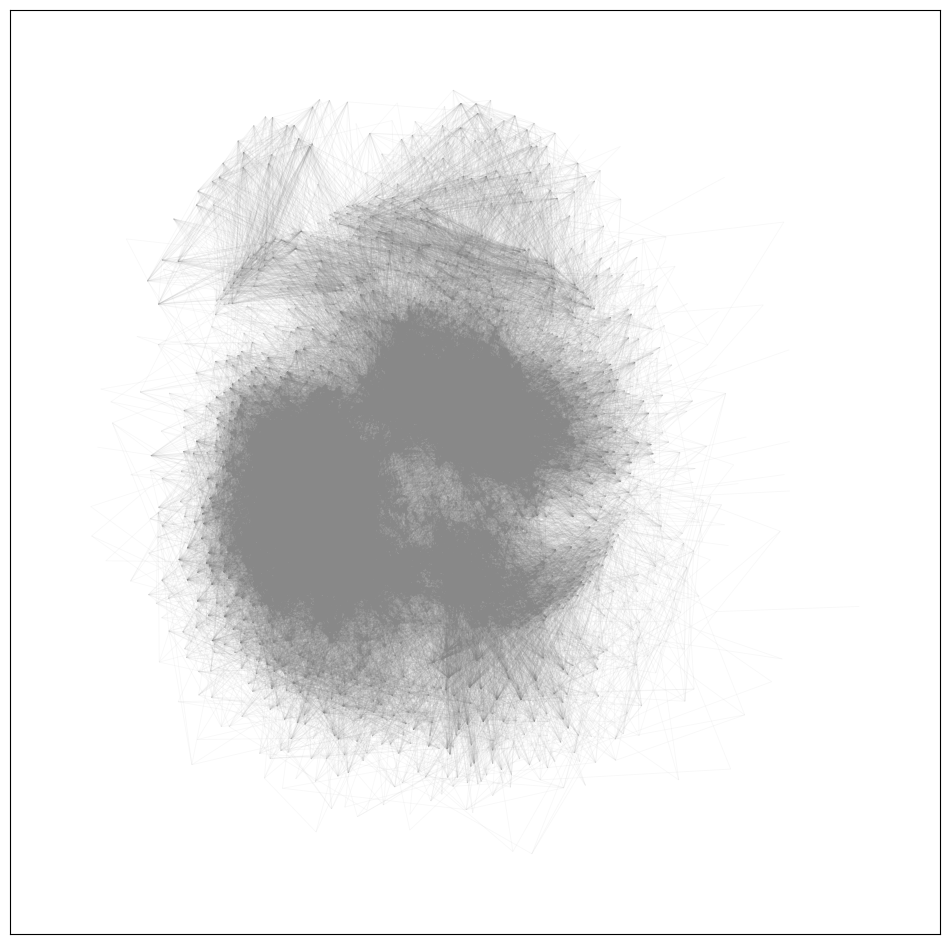

In [28]:
# 3. Visualize Topology
visualize_network_structure(G_sample)

In [12]:
# 4. Execute Simulations
df_results = execute_experiment_suite(G_sample, bc_map)



[INFO] Starting PILOT: 10 runs per setting -> 210 simulation units...
 -> Completed 50/210 pilot simulation units...
 -> Completed 100/210 pilot simulation units...
 -> Completed 150/210 pilot simulation units...
 -> Completed 200/210 pilot simulation units...

STATISTICAL RIGOR CHECK
Scenario [Random_Fixed_0.2]: StdDev=0.0091 -> R_req >= 5.5
Scenario [Random_Uniform]: StdDev=0.0340 -> R_req >= 76.6
Scenario [Degree_Uniform]: StdDev=0.1309 -> R_req >= 1137.0
Scenario [Betweenness_Uniform]: StdDev=0.1243 -> R_req >= 1024.6
Scenario [Random_Beta_Low]: StdDev=0.2914 -> R_req >= 5635.3
Scenario [Random_Beta_Mid]: StdDev=0.0018 -> R_req >= 0.2
Scenario [Degree_Beta_Mid]: StdDev=0.0684 -> R_req >= 310.8
Scenario [Betweenness_Beta_Mid]: StdDev=0.1317 -> R_req >= 1150.6
Scenario [Random_Beta_High]: StdDev=0.0003 -> R_req >= 0.0
Scenario [Degree_Beta_High]: StdDev=0.0008 -> R_req >= 0.0
Scenario [Betweenness_Beta_High]: StdDev=0.0009 -> R_req >= 0.1
Scenario [Random_Normal]: StdDev=0.0024 -> R

[INFO] Raw data saved to simulation_outputs\monte_carlo_results.csv
[INFO] Saved detailed (simulation_outputs\detailed_per_trial_summary.csv), aggregated (simulation_outputs\aggregated_summary_by_strategy_threshold.csv), ranking (simulation_outputs\ranking_by_threshold.csv)
[INFO] Generating Comparative Adoption Curves and Diagnostics (combined)...


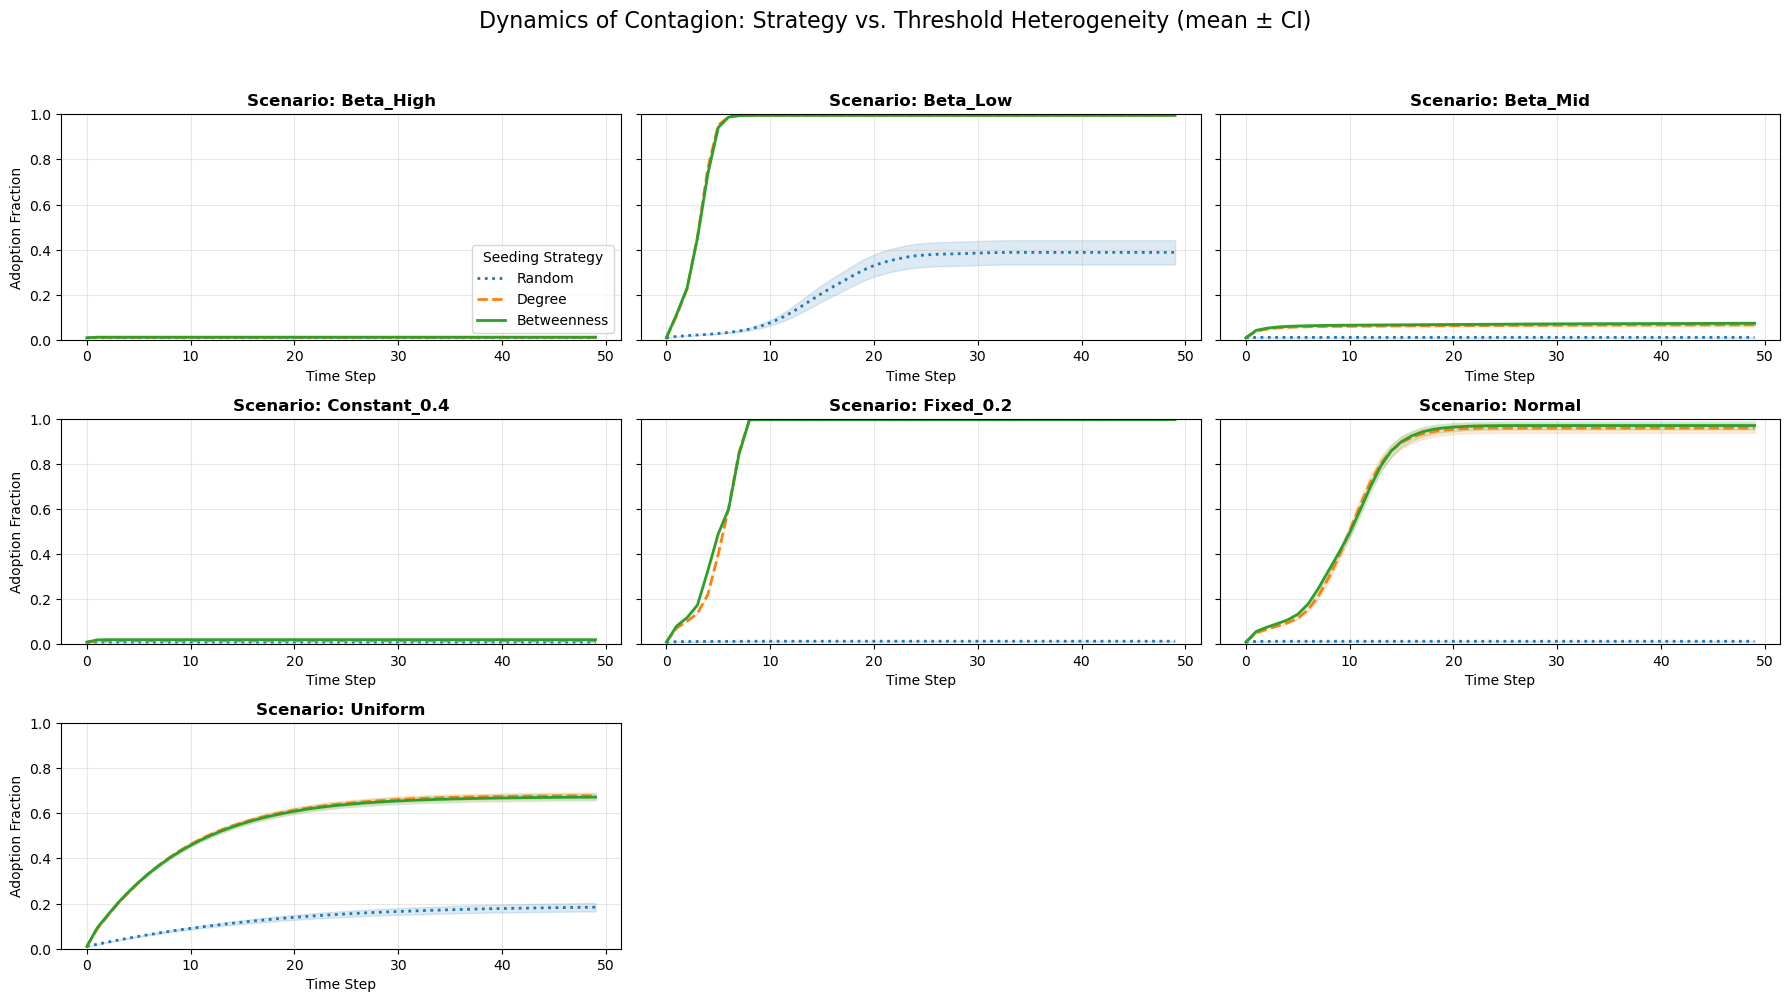

[INFO] Saved mean+CI curves to simulation_outputs\adoption_curves_comparison_fixed.png


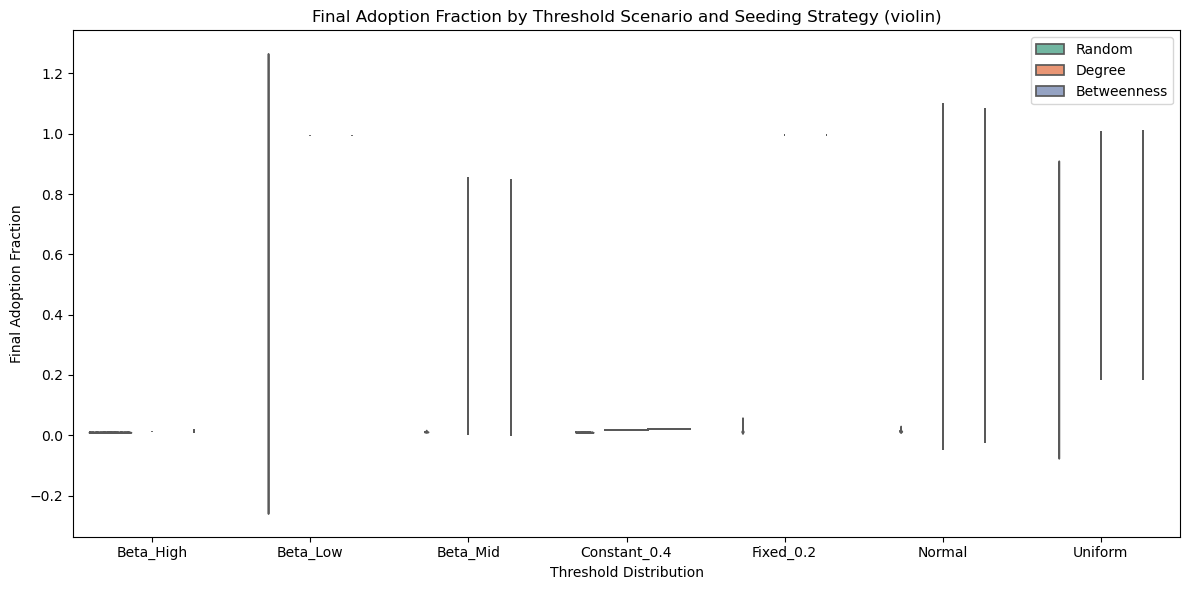

[INFO] Saved violin final fractions to simulation_outputs\violin_final_fraction.png


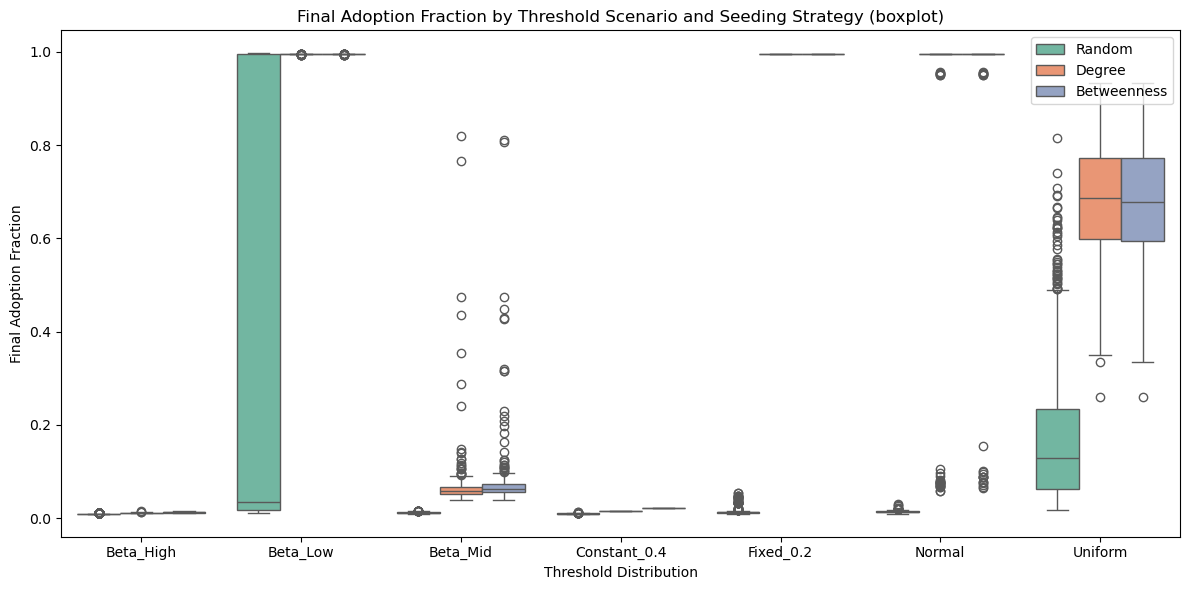

[INFO] Saved boxplot final fractions to simulation_outputs\boxplot_final_fraction.png


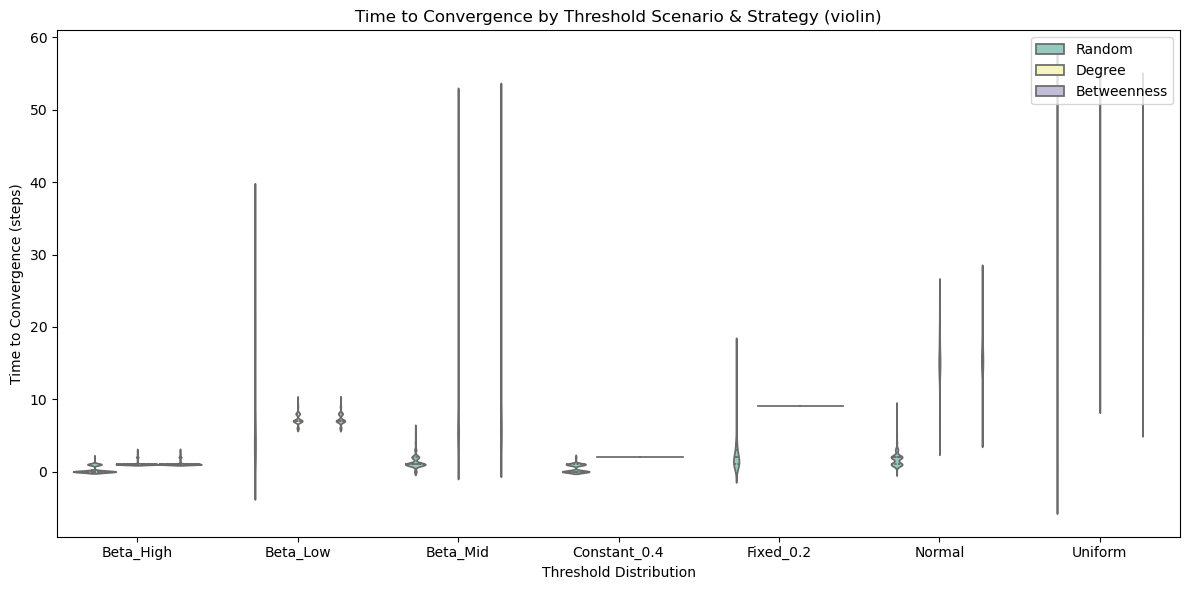

[INFO] Saved violin time-to-convergence to simulation_outputs\violin_time_to_converge.png


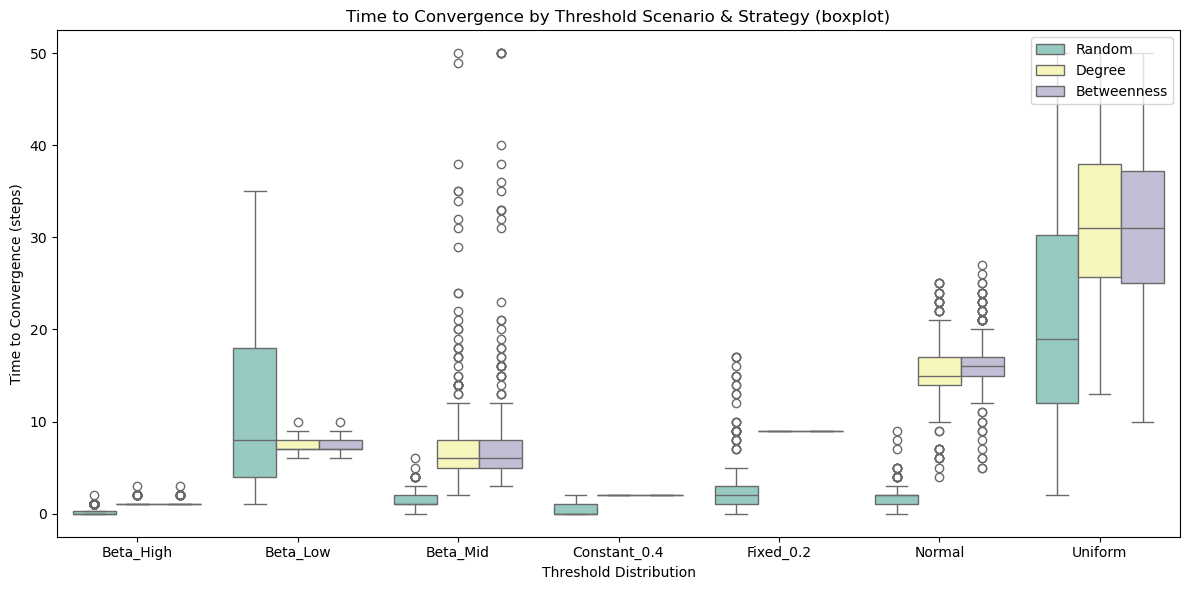

[INFO] Saved boxplot time-to-convergence to simulation_outputs\boxplot_time_to_converge.png
[INFO] Saved summary table to simulation_outputs\summary_stats_by_strategy_threshold.csv


In [18]:
# 5. Save Raw Data + teacher-style aggregated pivots + Visualize (guarded)
if isinstance(df_results, pd.DataFrame) and not df_results.empty:
    csv_path = os.path.join(OUTPUT_DIR, RESULTS_CSV)
    df_results.to_csv(csv_path, index=False)
    print(f"[INFO] Raw data saved to {csv_path}")

    # create  aggregated summary + pivot tables
    try:
        create_summary_tables(df_results, out_dir=OUTPUT_DIR)
    except Exception as e:
        print(f"[WARN] create_summary_tables failed: {e}")

    # 6. Visualize Results
    try:
        plot_comparative_curves(df_results)
    except Exception as e:
        print(f"[WARN] plot_comparative_curves failed: {e}")
else:
    print("[WARN] No results returned from execute_experiment_suite; skipping save/plots.")

In [ ]:

from IPython.display import display

csv_files = {
    'aggregated': os.path.join(OUTPUT_DIR, "aggregated_summary_by_strategy_threshold.csv"),
    'teacher_aggregated': os.path.join(OUTPUT_DIR, "aggregated_summary_by_strategy_threshold_teacherstyle.csv"),
    'summary_table': os.path.join(OUTPUT_DIR, "summary_stats_by_strategy_threshold.csv"),
    'ranking': os.path.join(OUTPUT_DIR, "ranking_by_threshold.csv"),
    'detailed': os.path.join(OUTPUT_DIR, "detailed_per_trial_summary.csv"),
    'pivot_final': os.path.join(OUTPUT_DIR, "pivot_final_adoption.csv"),
    'pivot_cascade': os.path.join(OUTPUT_DIR, "pivot_cascade_prob.csv"),
    'pivot_eff': os.path.join(OUTPUT_DIR, "pivot_efficiency.csv"),
}

print("\n[INFO] Loading saved CSV summaries from", OUTPUT_DIR)
for key, path in csv_files.items():
    if os.path.exists(path):
        try:
            df_csv = pd.read_csv(path)
            print(f"\n[INFO] {os.path.basename(path)} — rows={len(df_csv):,}, cols={len(df_csv.columns)}")
            display(df_csv.head(10))
        except Exception as e:
            print(f"[WARN] Failed reading {path}: {e}")
    else:
        print(f"[WARN] {os.path.basename(path)} not found — skipping.")



[INFO] Loading saved CSV summaries from simulation_outputs

[INFO] aggregated_summary_by_strategy_threshold.csv — rows=21, cols=10


Strategy Threshold_Dist  n_runs  mean_final  std_final  median_final  \
0  Betweenness      Beta_High     500    0.012820   0.000793       0.01250   
1  Betweenness       Beta_Low     500    0.995454   0.000241       0.99550   
2  Betweenness       Beta_Mid     500    0.074467   0.063880       0.06350   
3  Betweenness   Constant_0.4     500    0.021000   0.000000       0.02100   
4  Betweenness      Fixed_0.2     500    0.995500   0.000000       0.99550   
5  Betweenness         Normal     500    0.969493   0.149889       0.99550   
6  Betweenness        Uniform     500    0.671729   0.128926       0.67725   
7       Degree      Beta_High     500    0.011430   0.000681       0.01150   
8       Degree       Beta_Low     500    0.995454   0.000241       0.99550   
9       Degree       Beta_Mid     500    0.067377   0.057348       0.05900   

   q25_final  q75_final  mean_time_to_conv  std_time_to_conv  
0   0.012000   0.013500              1.060          0.246010  
1   0.995500   0.995500              7.292          0.718170  
2   0.056000   0.073000              7.740          6.438269  
3   0.021000   0.021000              2.000          0.000000  
4   0.995500   0.995500              9.000          0.000000  
5   0.995500   0.995500             16.114          2.738614  
6   0.593875   0.772125             31.968          8.871323  
7   0.011000   0.012000              1.052          0.231090  
8   0.995500   0.995500              7.224          0.680257  
9   0.052000   0.067625              7.236          5.256955


[INFO] aggregated_summary_by_strategy_threshold_teacherstyle.csv — rows=21, cols=9


Strategy Threshold_Dist  n_runs  FinalAdoption  Final_STD  CascadeProb  \
0  Betweenness      Beta_High     500       0.012820   0.000793        0.000   
1  Betweenness       Beta_Low     500       0.995454   0.000241        1.000   
2  Betweenness       Beta_Mid     500       0.074467   0.063880        0.004   
3  Betweenness   Constant_0.4     500       0.021000   0.000000        0.000   
4  Betweenness      Fixed_0.2     500       0.995500   0.000000        1.000   
5  Betweenness         Normal     500       0.969493   0.149889        0.972   
6  Betweenness        Uniform     500       0.671729   0.128926        0.886   
7       Degree      Beta_High     500       0.011430   0.000681        0.000   
8       Degree       Beta_Low     500       0.995454   0.000241        1.000   
9       Degree       Beta_Mid     500       0.067377   0.057348        0.004   

   Time50  Seeds  Efficiency  
0   1.060     20    0.000641  
1   7.292     20    0.049773  
2   7.740     20    0.003723  
3   2.000     20    0.001050  
4   9.000     20    0.049775  
5  16.114     20    0.048475  
6  31.968     20    0.033586  
7   1.052     20    0.000571  
8   7.224     20    0.049773  
9   7.236     20    0.003369


[INFO] summary_stats_by_strategy_threshold.csv — rows=15, cols=6


Strategy Threshold_Dist  Final_Mean  Final_STD  TimeToConv_Mean  \
0  Betweenness      Beta_High    0.046350   0.004259         2.400000   
1  Betweenness       Beta_Low    0.999363   0.000482         6.394904   
2  Betweenness       Beta_Mid    0.307450   0.027512        12.400000   
3  Betweenness      Fixed_0.2    1.000000   0.000000         4.000000   
4  Betweenness        Uniform    0.487950   0.051516        14.500000   
5       Degree      Beta_High    0.047050   0.004214         2.400000   
6       Degree       Beta_Low    0.999371   0.000485         6.477987   
7       Degree       Beta_Mid    0.315350   0.027324        13.900000   
8       Degree      Fixed_0.2    1.000000   0.000000         4.000000   
9       Degree        Uniform    0.495650   0.060412        14.500000   

   TimeToConv_STD  
0        0.663989  
1        0.657871  
2        2.942331  
3        0.000000  
4        4.888537  
5        0.663989  
6        0.604168  
7        4.138146  
8        0.000000  
9        5.128607


[INFO] ranking_by_threshold.csv — rows=21, cols=10


Strategy Threshold_Dist  n_runs  mean_final  std_final  median_final  \
0  Betweenness      Beta_High     500    0.012820   0.000793       0.01250   
1       Degree      Beta_High     500    0.011430   0.000681       0.01150   
2       Random      Beta_High     500    0.010143   0.000267       0.01000   
3  Betweenness       Beta_Low     500    0.995454   0.000241       0.99550   
4       Degree       Beta_Low     500    0.995454   0.000241       0.99550   
5       Random       Beta_Low     500    0.388327   0.468053       0.03575   
6  Betweenness       Beta_Mid     500    0.074467   0.063880       0.06350   
7       Degree       Beta_Mid     500    0.067377   0.057348       0.05900   
8       Random       Beta_Mid     500    0.011849   0.001318       0.01150   
9  Betweenness   Constant_0.4     500    0.021000   0.000000       0.02100   

   q25_final  q75_final  mean_time_to_conv  std_time_to_conv  
0     0.0120   0.013500              1.060          0.246010  
1     0.0110   0.012000              1.052          0.231090  
2     0.0100   0.010125              0.252          0.439183  
3     0.9955   0.995500              7.292          0.718170  
4     0.9955   0.995500              7.224          0.680257  
5     0.0185   0.995500             11.238          8.403487  
6     0.0560   0.073000              7.740          6.438269  
7     0.0520   0.067625              7.236          5.256955  
8     0.0110   0.012500              1.338          0.790573  
9     0.0210   0.021000              2.000          0.000000


[INFO] detailed_per_trial_summary.csv — rows=10,500, cols=5


Trial     Strategy Threshold_Dist  Final_Fraction  TimeToConverge
0      0       Random      Fixed_0.2          0.0135               2
1      0       Degree      Fixed_0.2          0.9955               9
2      0  Betweenness      Fixed_0.2          0.9955               9
3      1       Random      Fixed_0.2          0.0155               2
4      1       Degree      Fixed_0.2          0.9955               9
5      1  Betweenness      Fixed_0.2          0.9955               9
6      2       Random      Fixed_0.2          0.0115               1
7      2       Degree      Fixed_0.2          0.9955               9
8      2  Betweenness      Fixed_0.2          0.9955               9
9      3       Random      Fixed_0.2          0.0125               2


[INFO] pivot_final_adoption.csv — rows=3, cols=8


Strategy  Beta_High  Beta_Low  Beta_Mid  Constant_0.4  Fixed_0.2  \
0  Betweenness   0.012820  0.995454  0.074467      0.021000     0.9955   
1       Degree   0.011430  0.995454  0.067377      0.016500     0.9955   
2       Random   0.010143  0.388327  0.011849      0.010336     0.0141   

     Normal   Uniform  
0  0.969493  0.671729  
1  0.958127  0.678336  
2  0.013780  0.184418


[INFO] pivot_cascade_prob.csv — rows=3, cols=8


Strategy  Beta_High  Beta_Low  Beta_Mid  Constant_0.4  Fixed_0.2  \
0  Betweenness        0.0     1.000     0.004           0.0        1.0   
1       Degree        0.0     1.000     0.004           0.0        1.0   
2       Random        0.0     0.372     0.000           0.0        0.0   

   Normal  Uniform  
0   0.972    0.886  
1   0.960    0.908  
2   0.000    0.076


[INFO] pivot_efficiency.csv — rows=3, cols=8


Strategy  Beta_High  Beta_Low  Beta_Mid  Constant_0.4  Fixed_0.2  \
0  Betweenness   0.000641  0.049773  0.003723      0.001050   0.049775   
1       Degree   0.000571  0.049773  0.003369      0.000825   0.049775   
2       Random   0.000507  0.019416  0.000592      0.000517   0.000705   

     Normal   Uniform  
0  0.048475  0.033586  
1  0.047906  0.033917  
2  0.000689  0.009221

[INFO] Saved degree histogram to simulation_outputs\degree_hist.png
[INFO] Saved degree CCDF to simulation_outputs\degree_ccdf.png


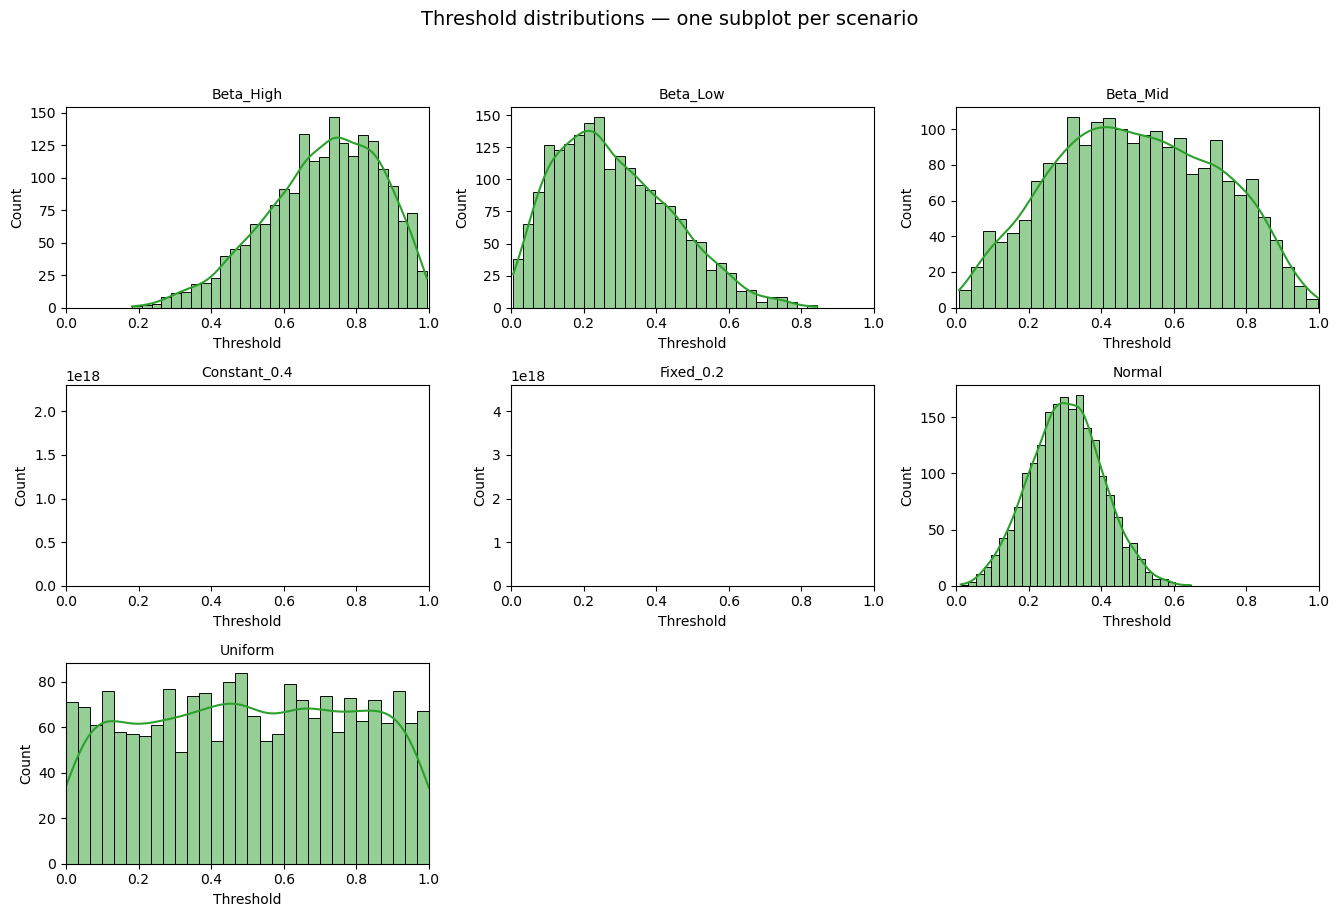

[INFO] Saved thresholds grid to simulation_outputs\thresholds_grid.png


C:\Users\amdev\AppData\Local\Temp\ipykernel_14128\1897359635.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=final_df, x=by, y='Final_Fraction', inner='quartile', palette="Set2")


[INFO] Saved final-fraction violin to simulation_outputs\final_frac_hist.png
[INFO] Saved time-to-converge histogram to simulation_outputs\time_to_converge_hist.png
[INFO] Saved pivot heatmap to simulation_outputs\pivot_heatmap.png
[INFO] Saved degree vs betweenness scatter to simulation_outputs\deg_vs_bc.png


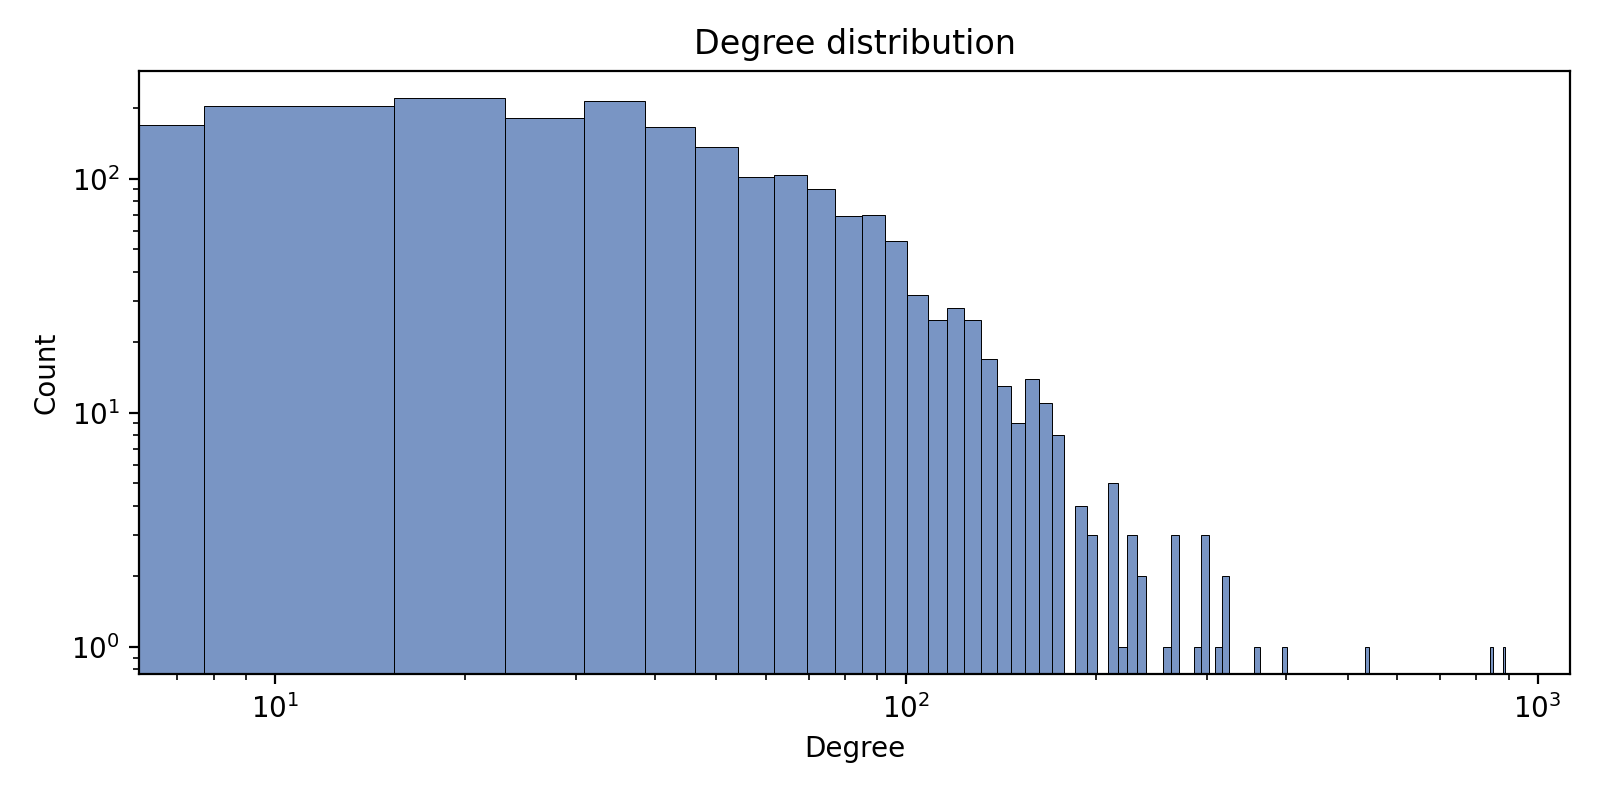

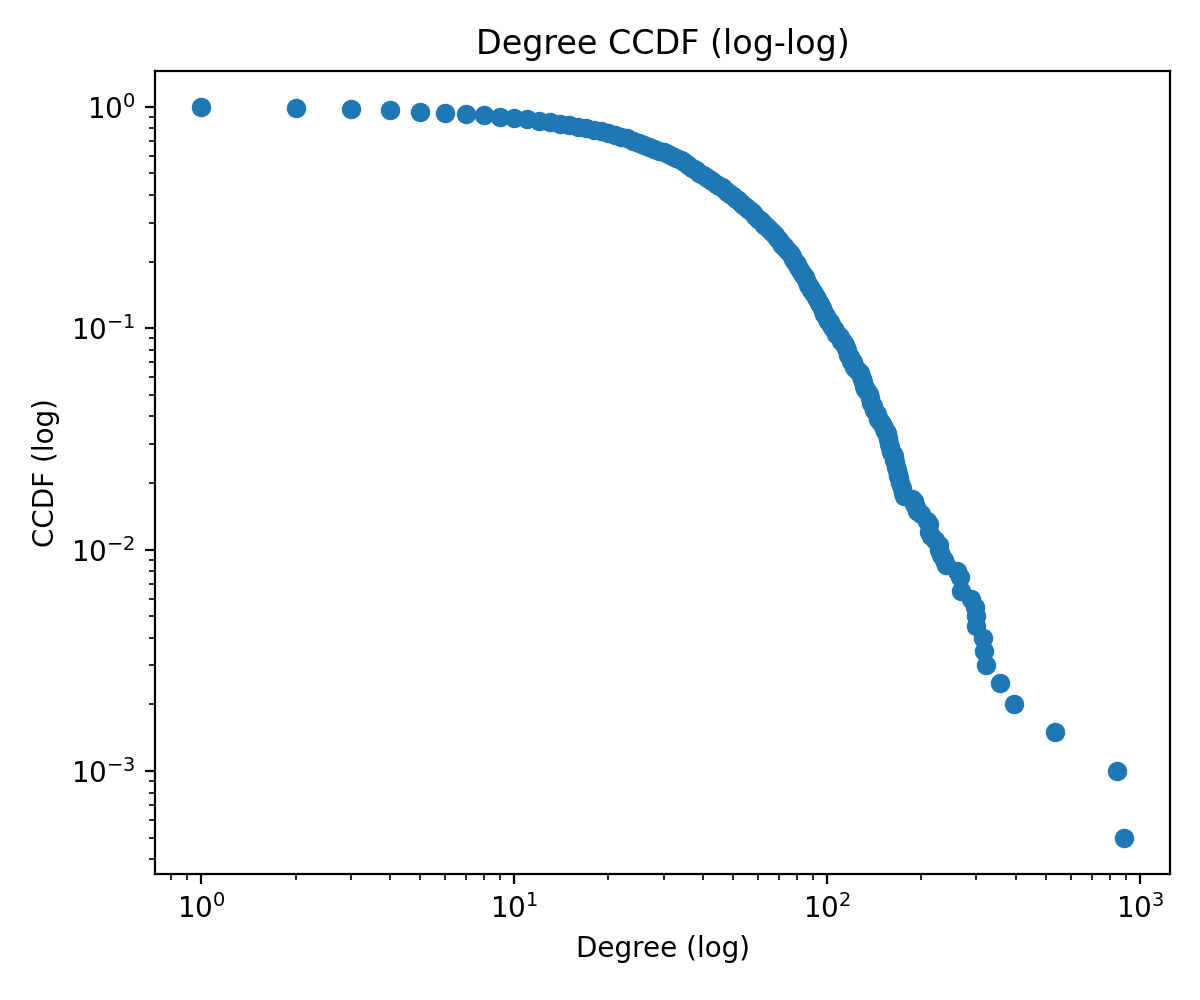

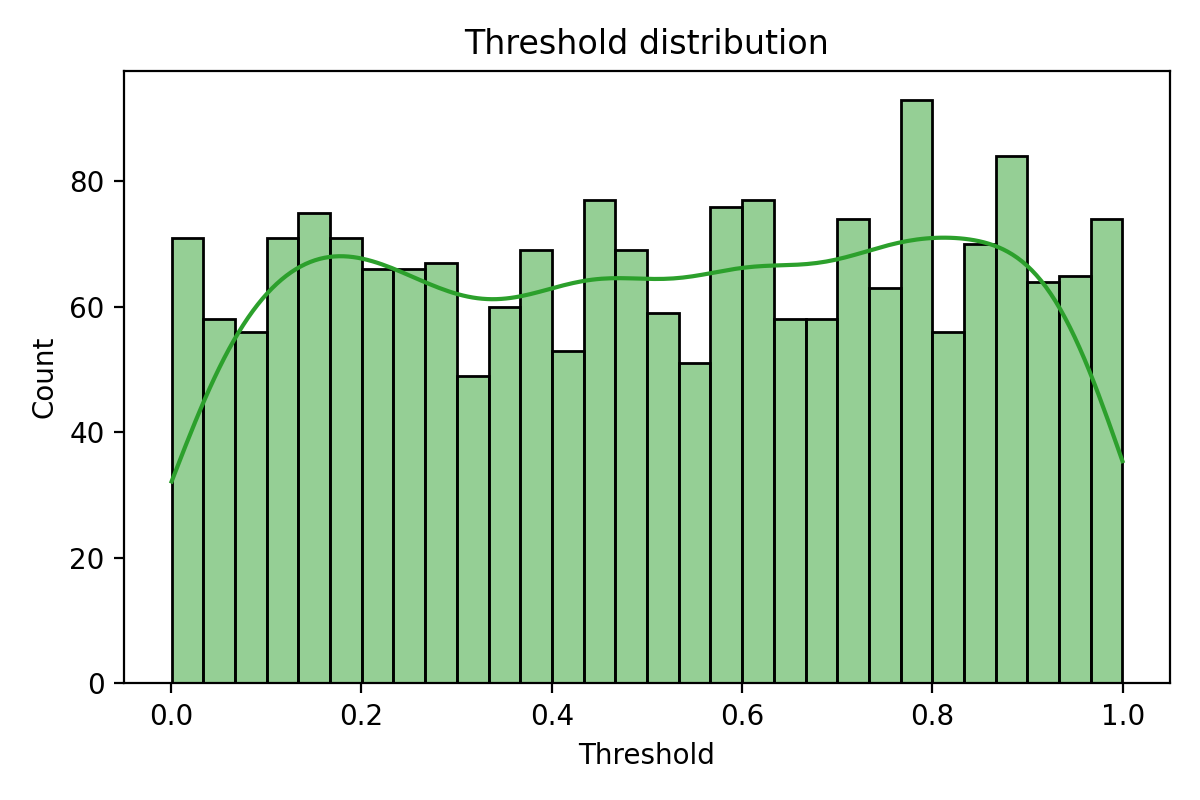

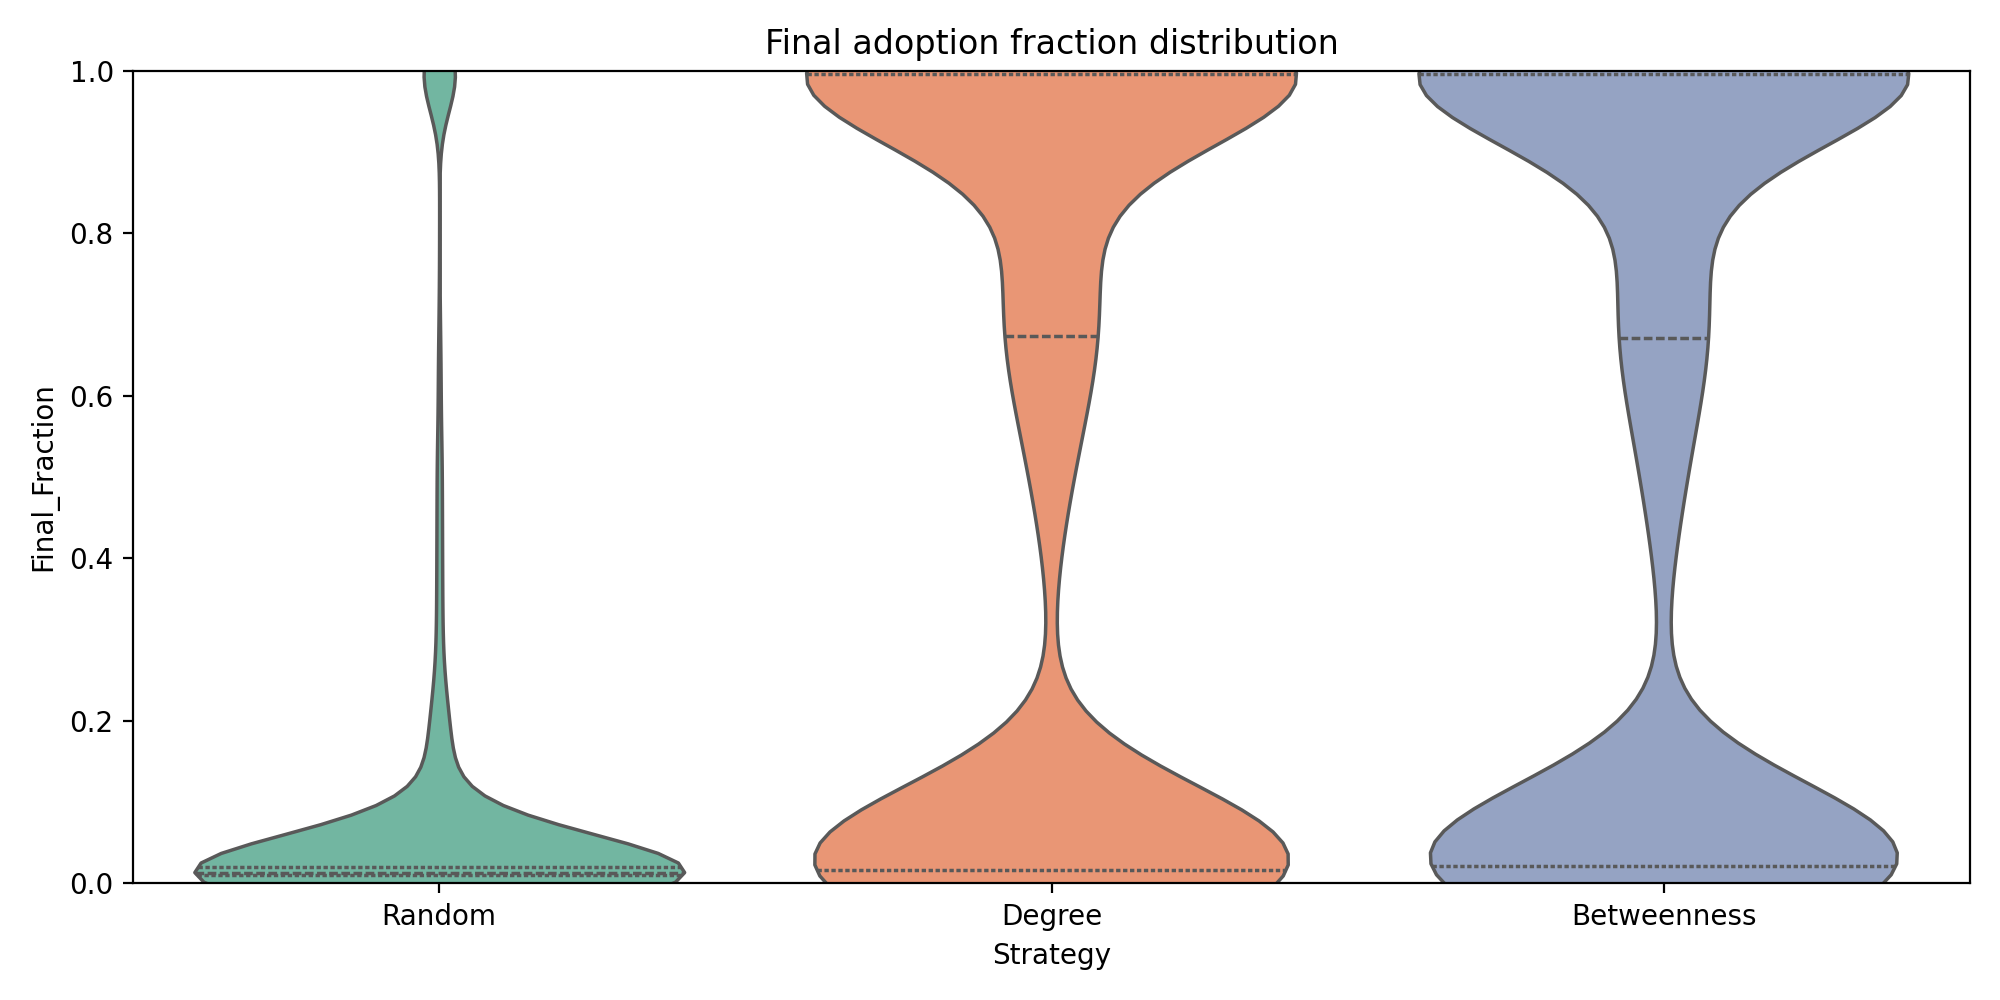

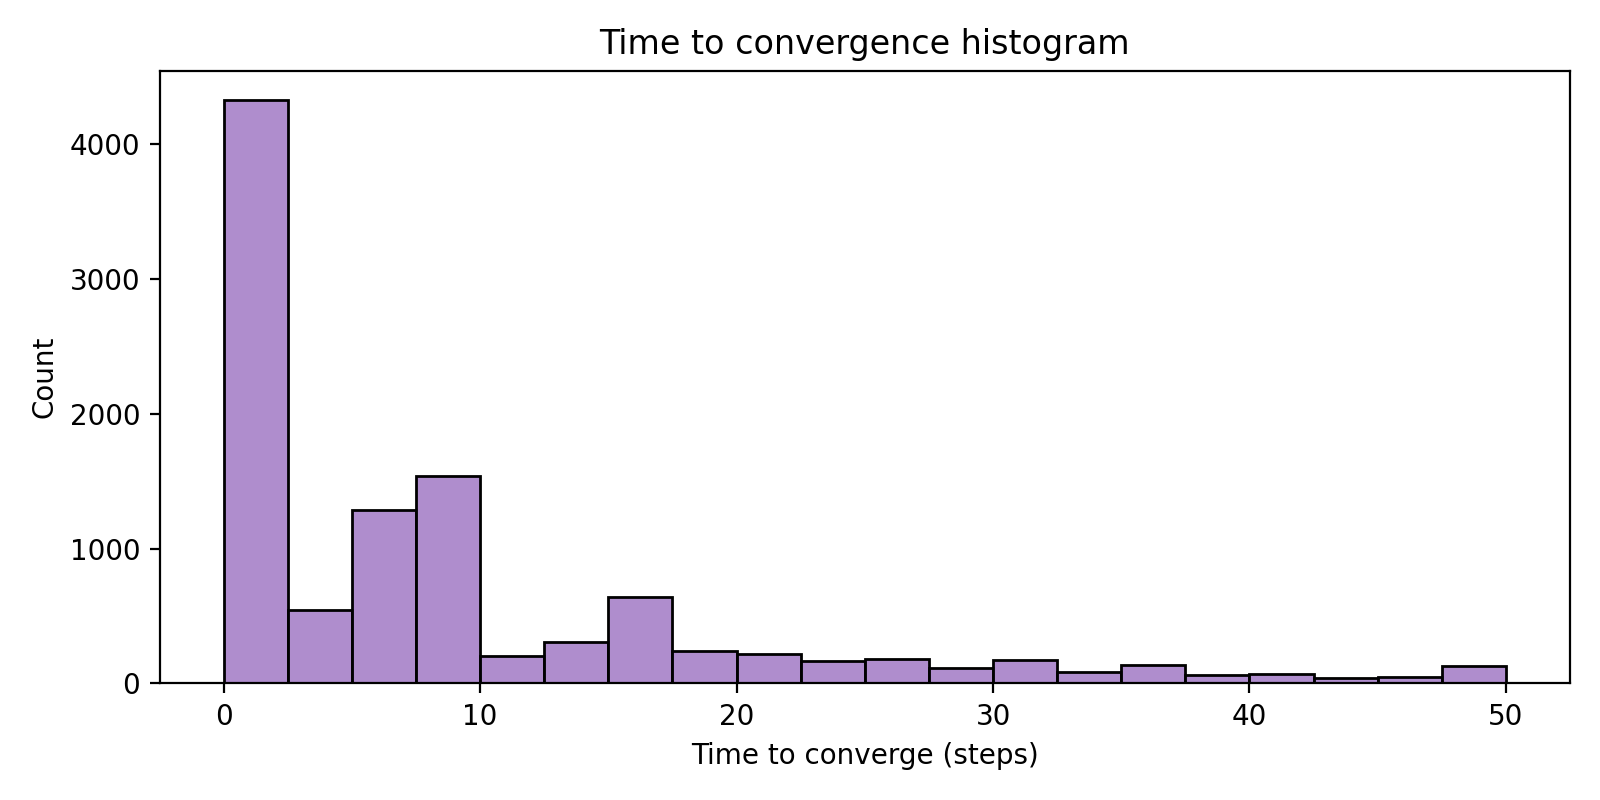

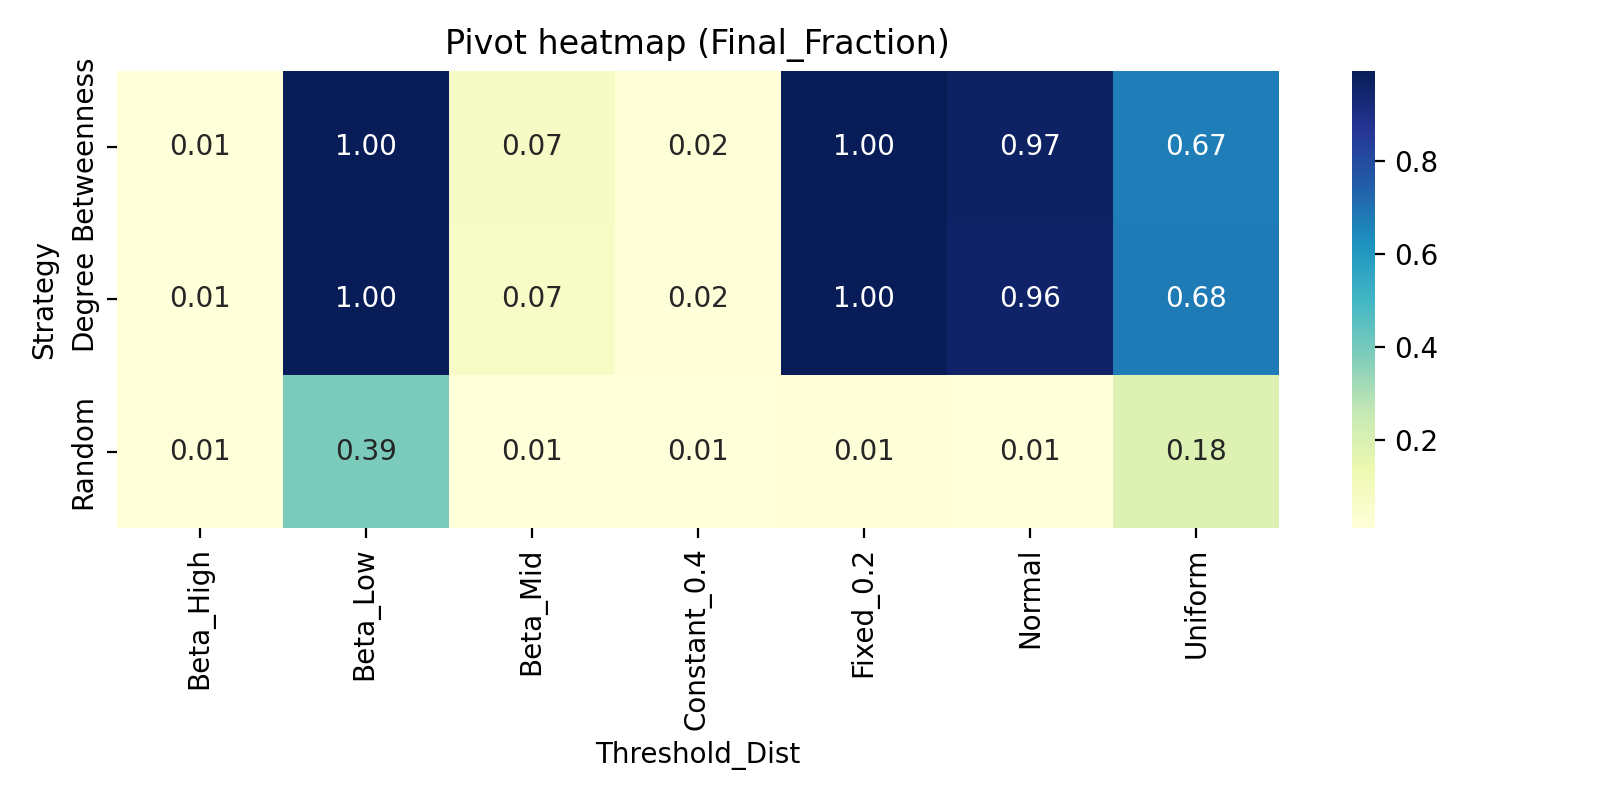

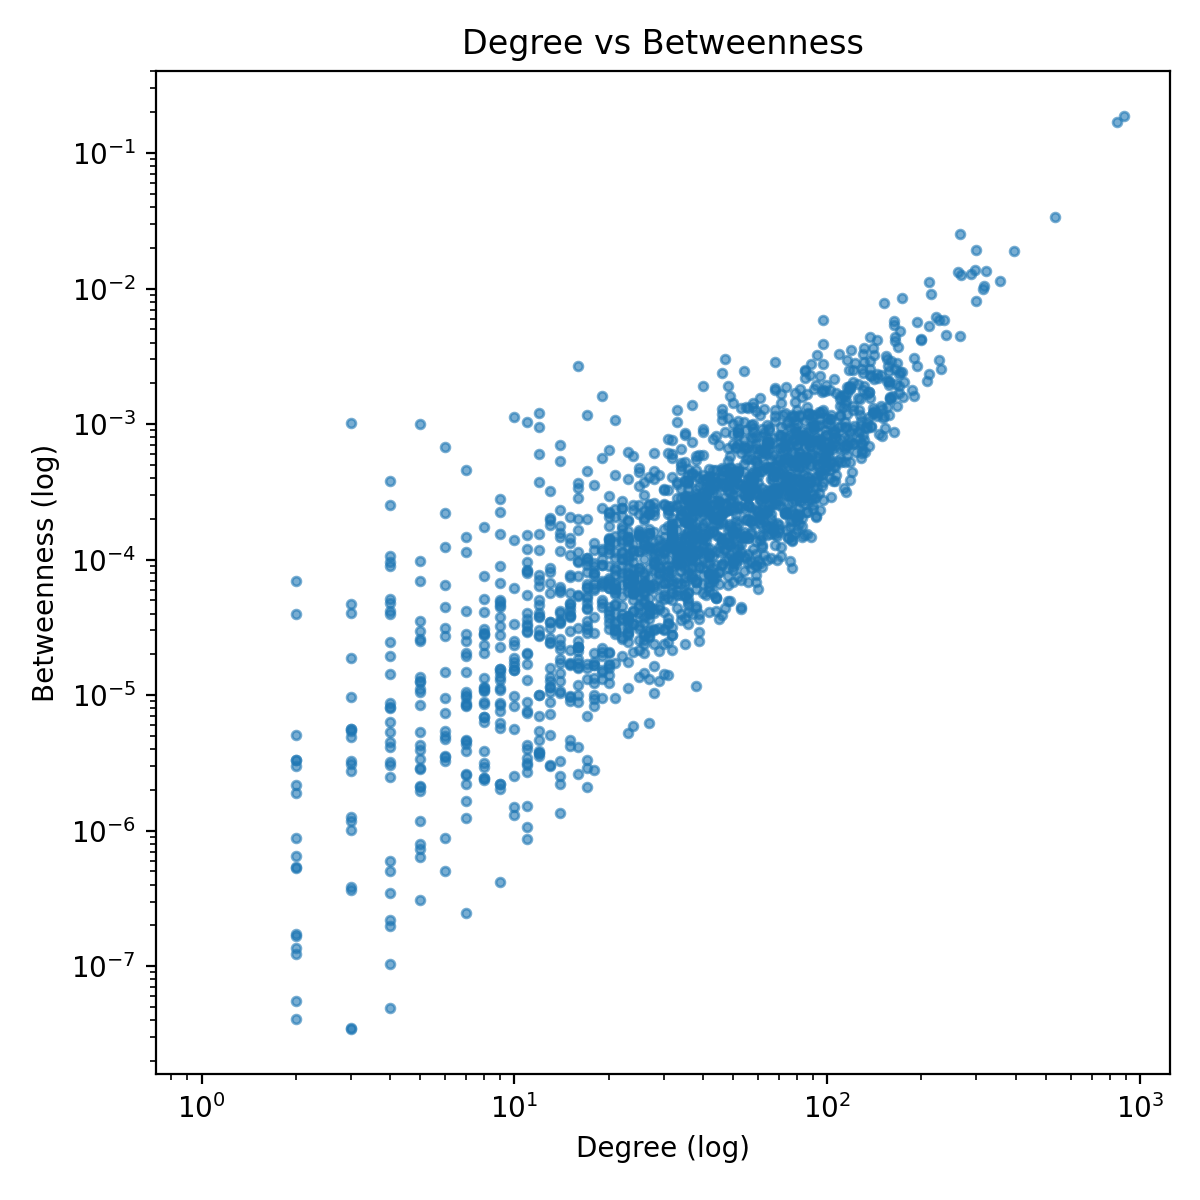

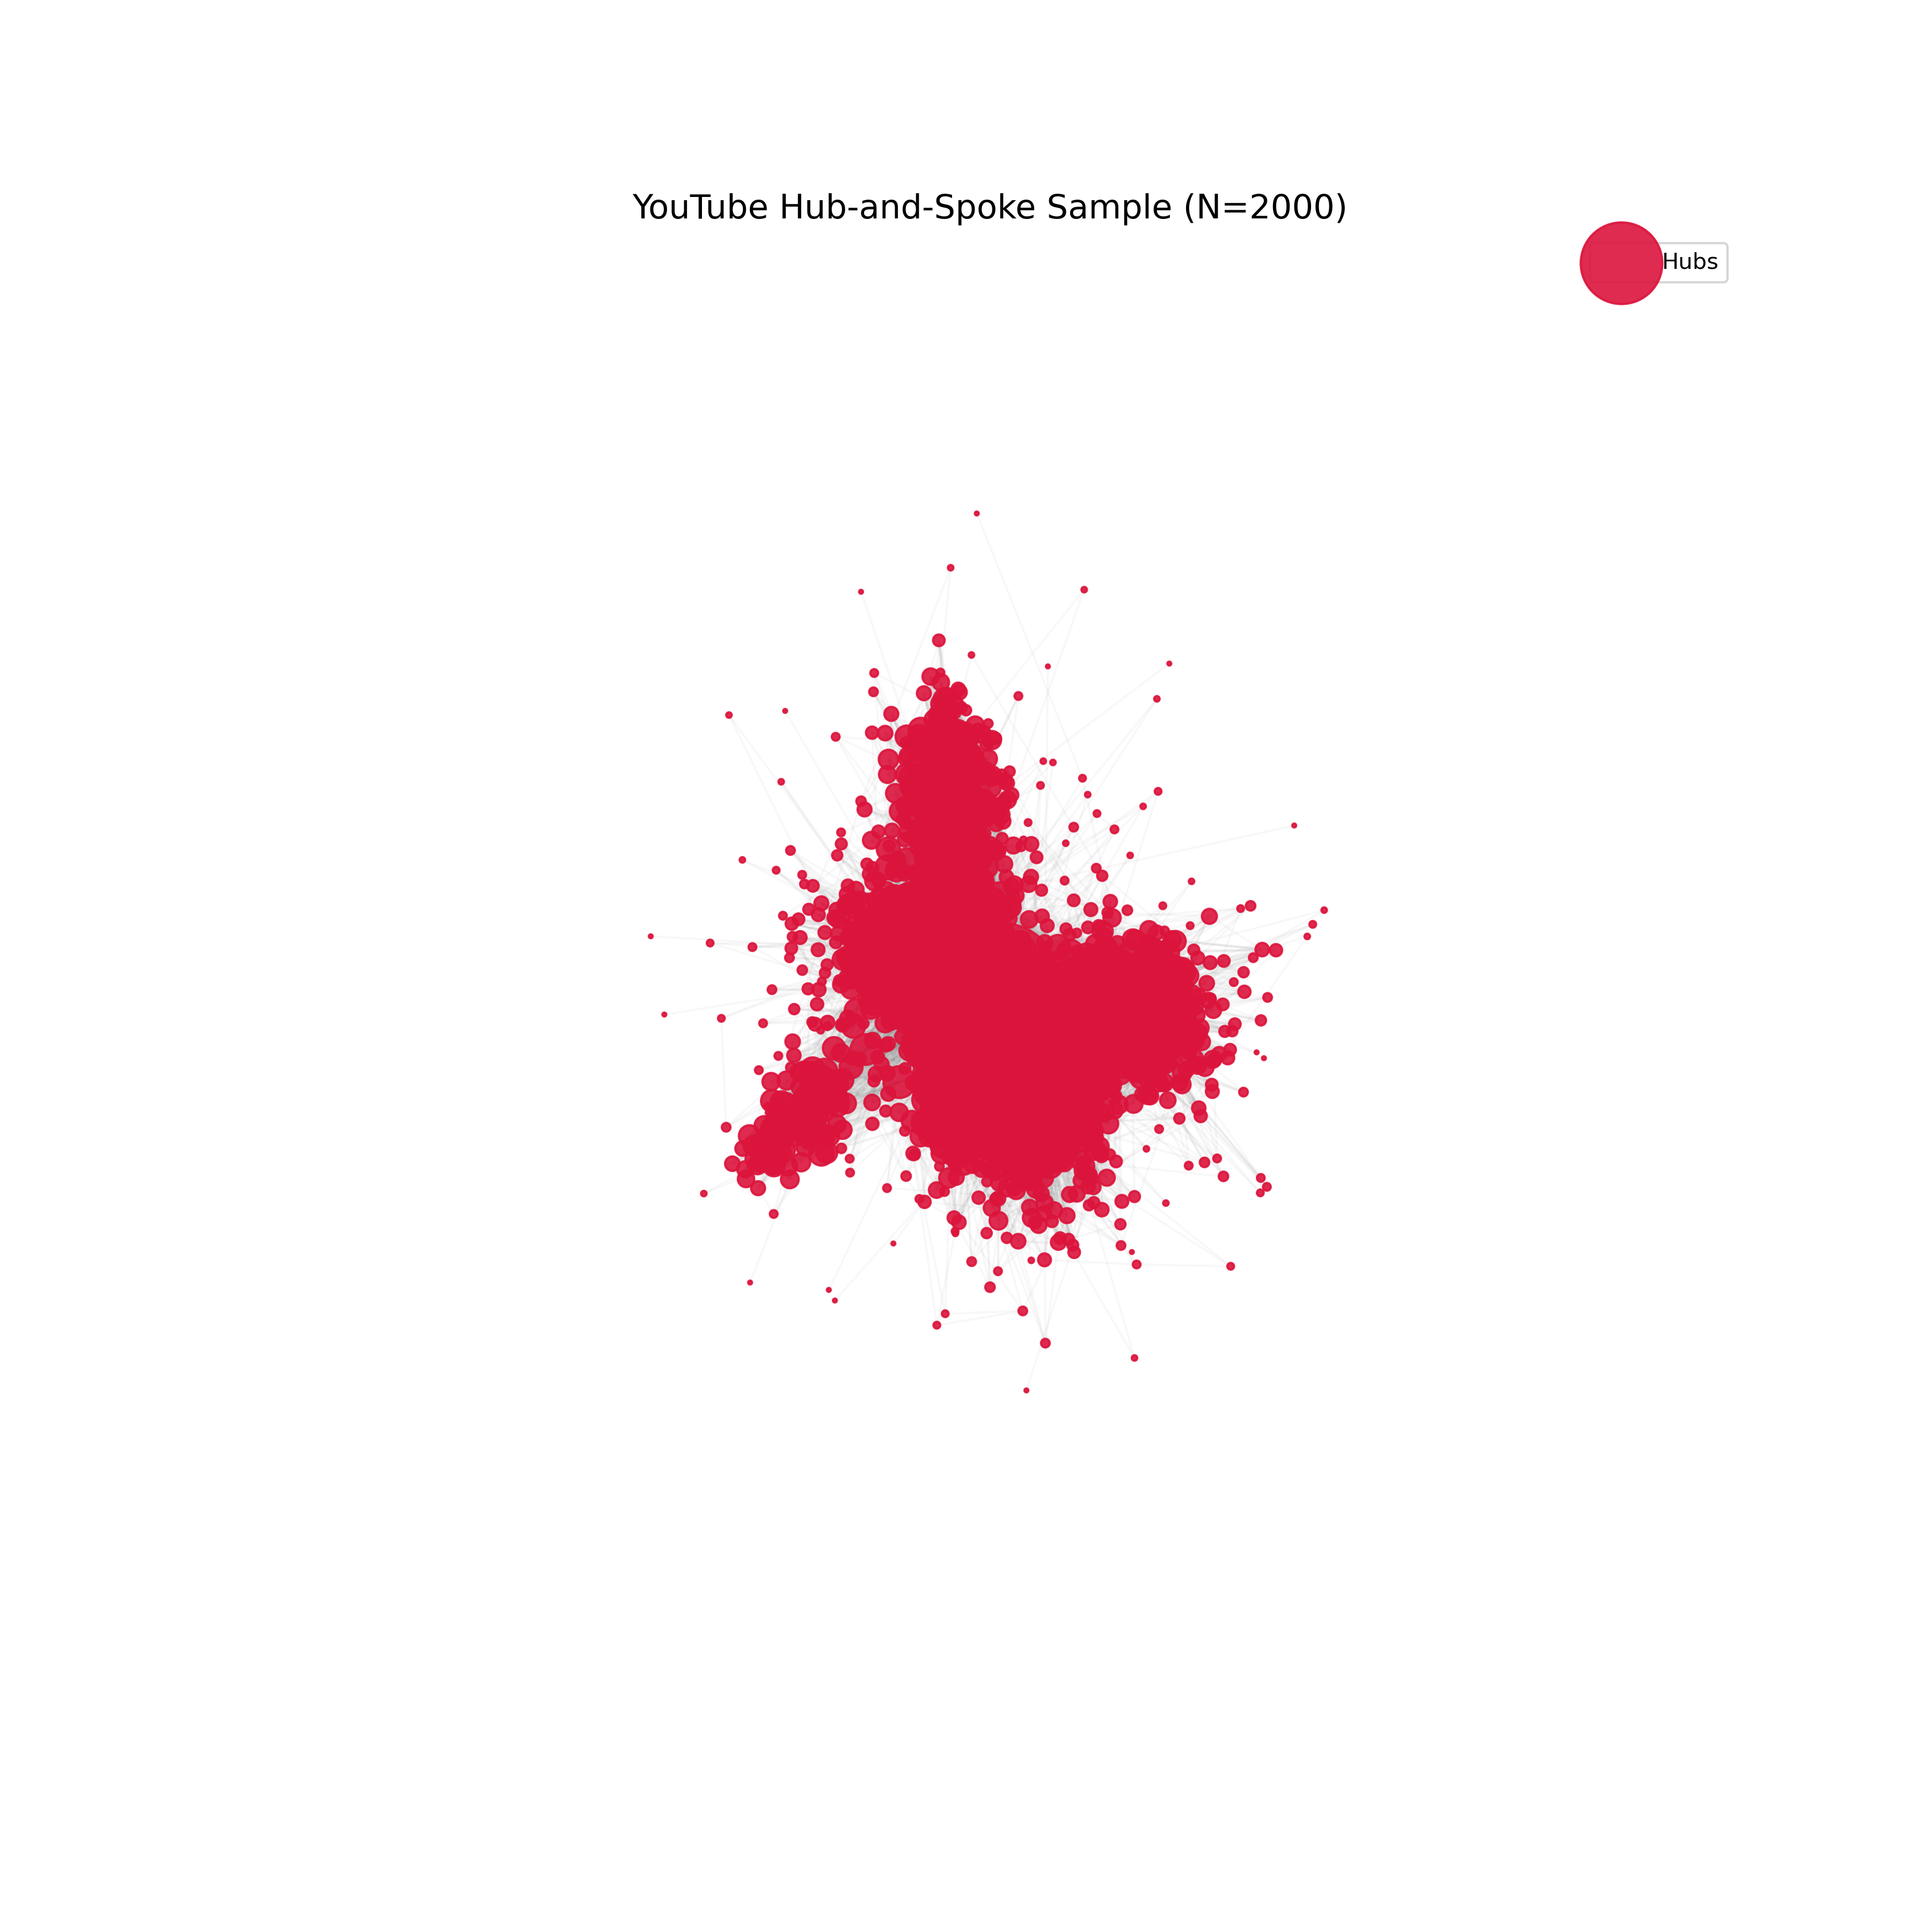

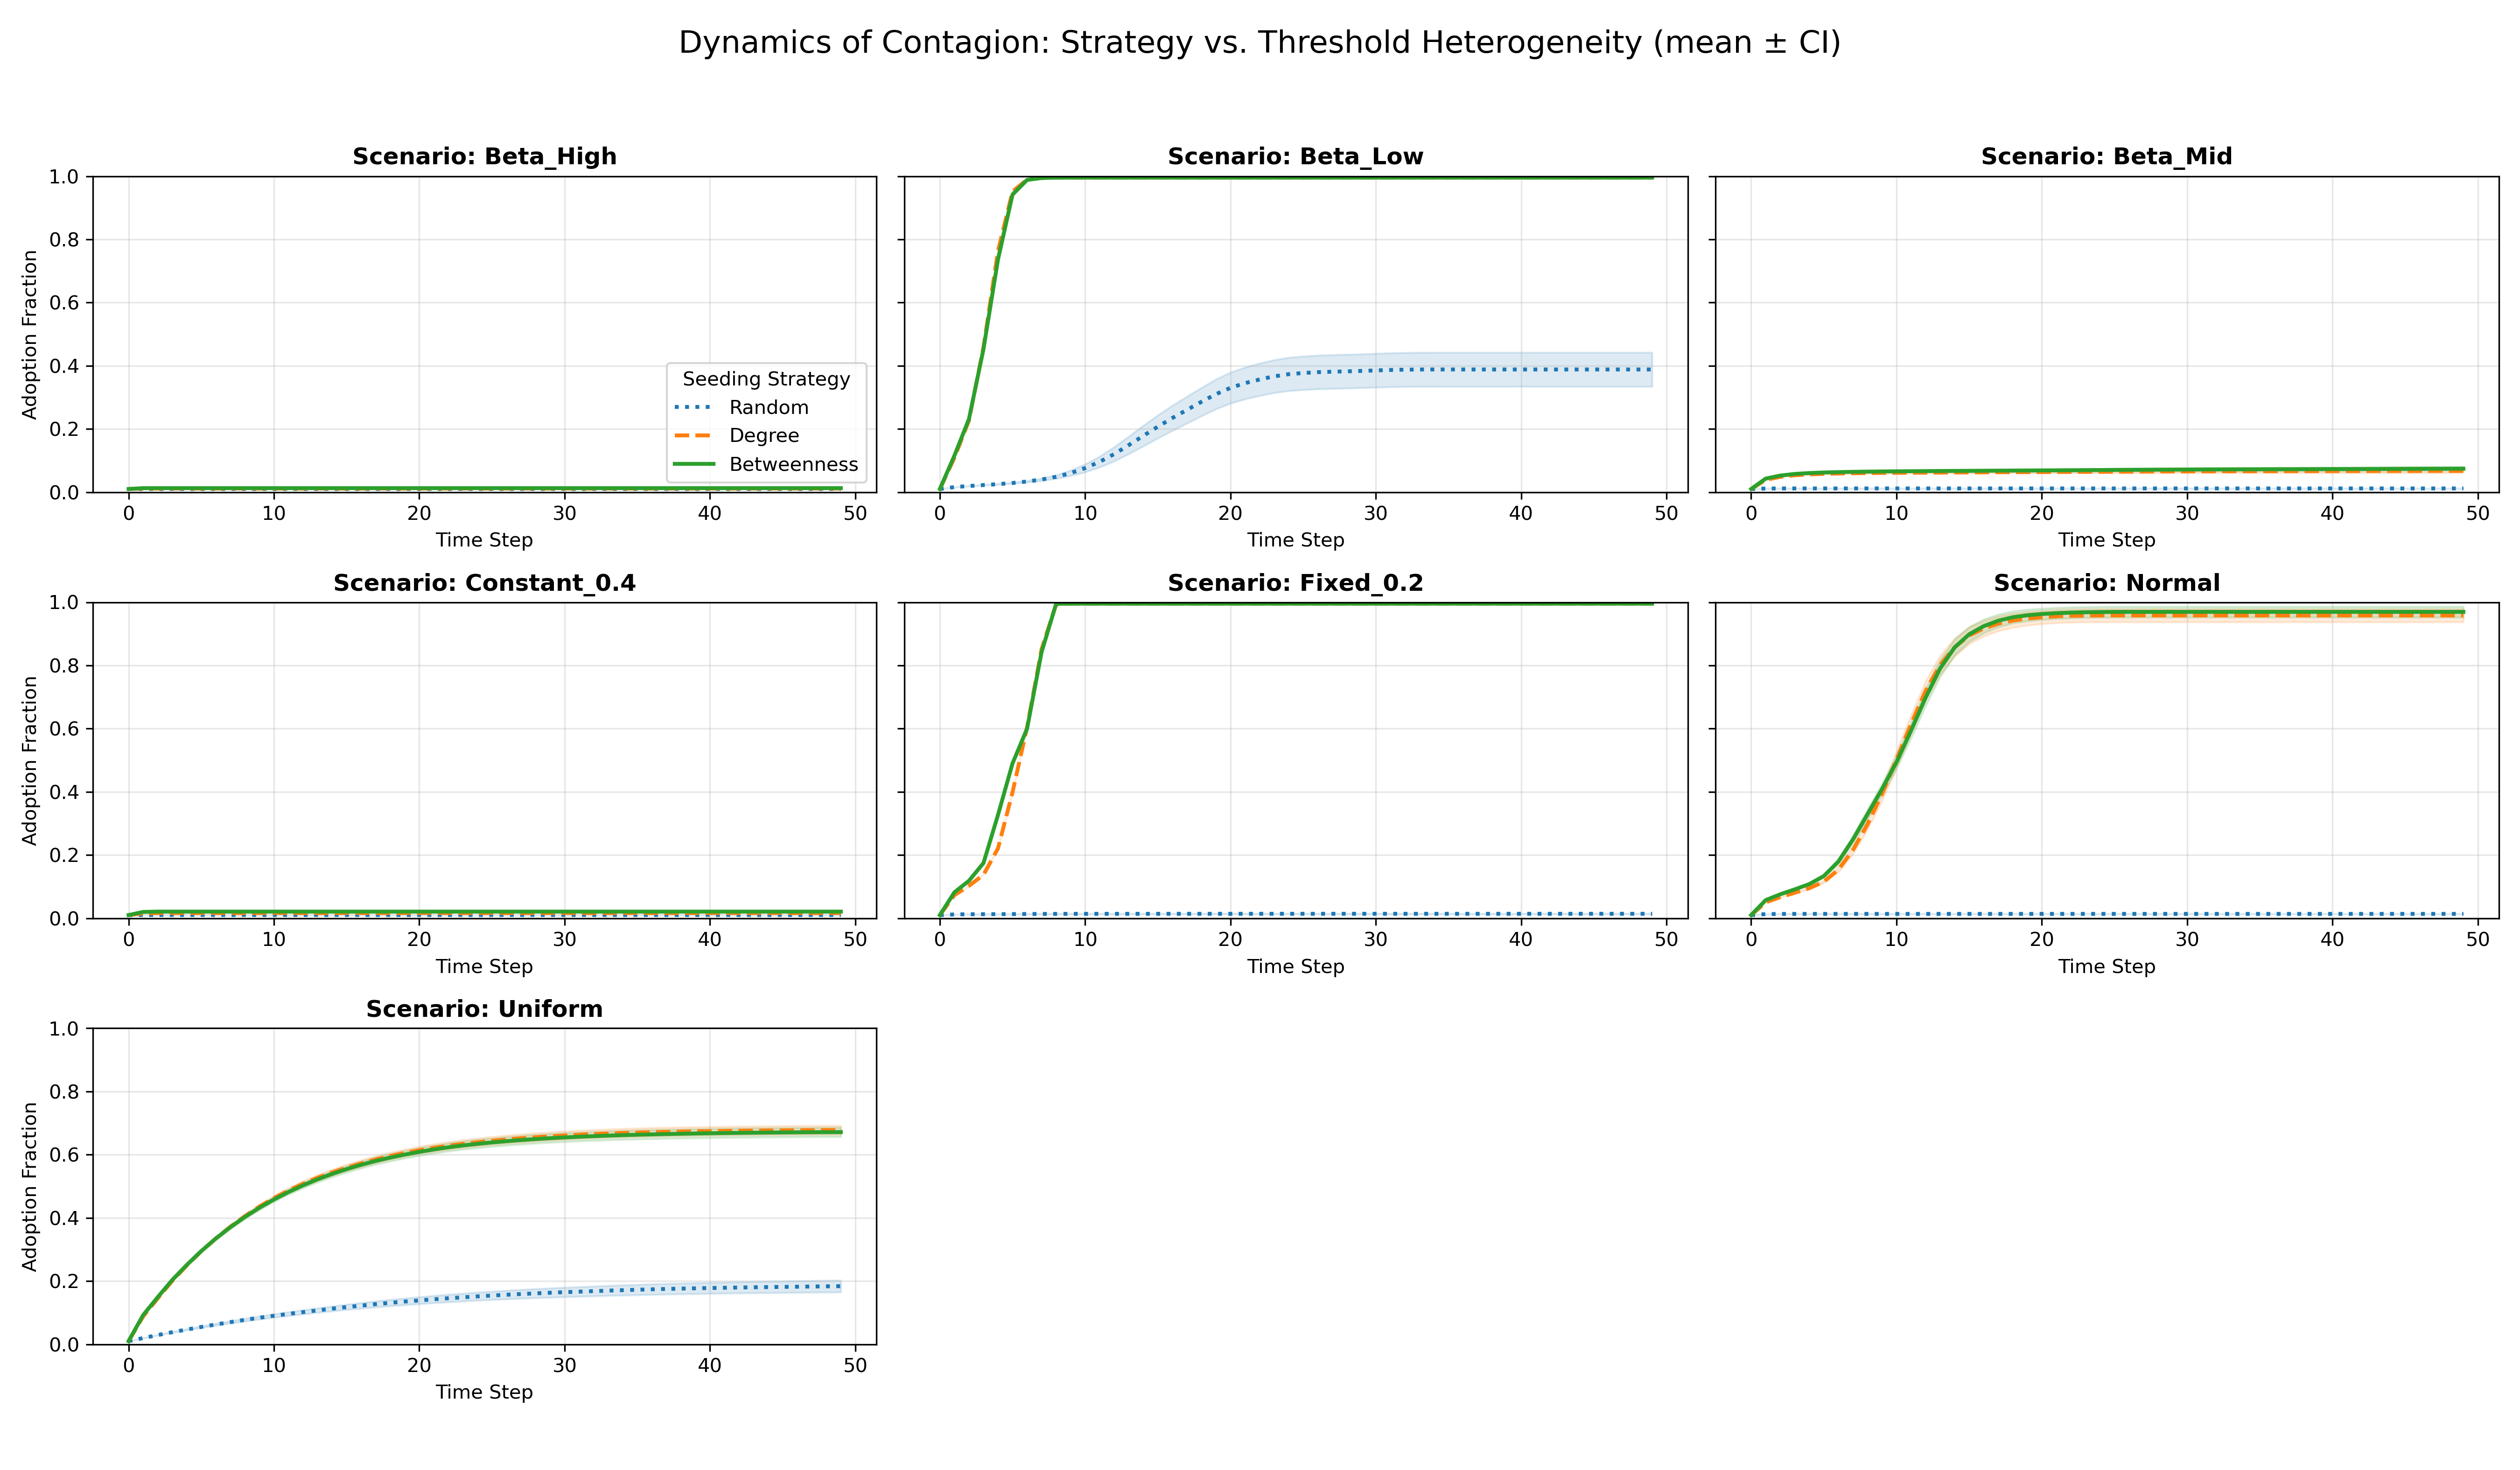

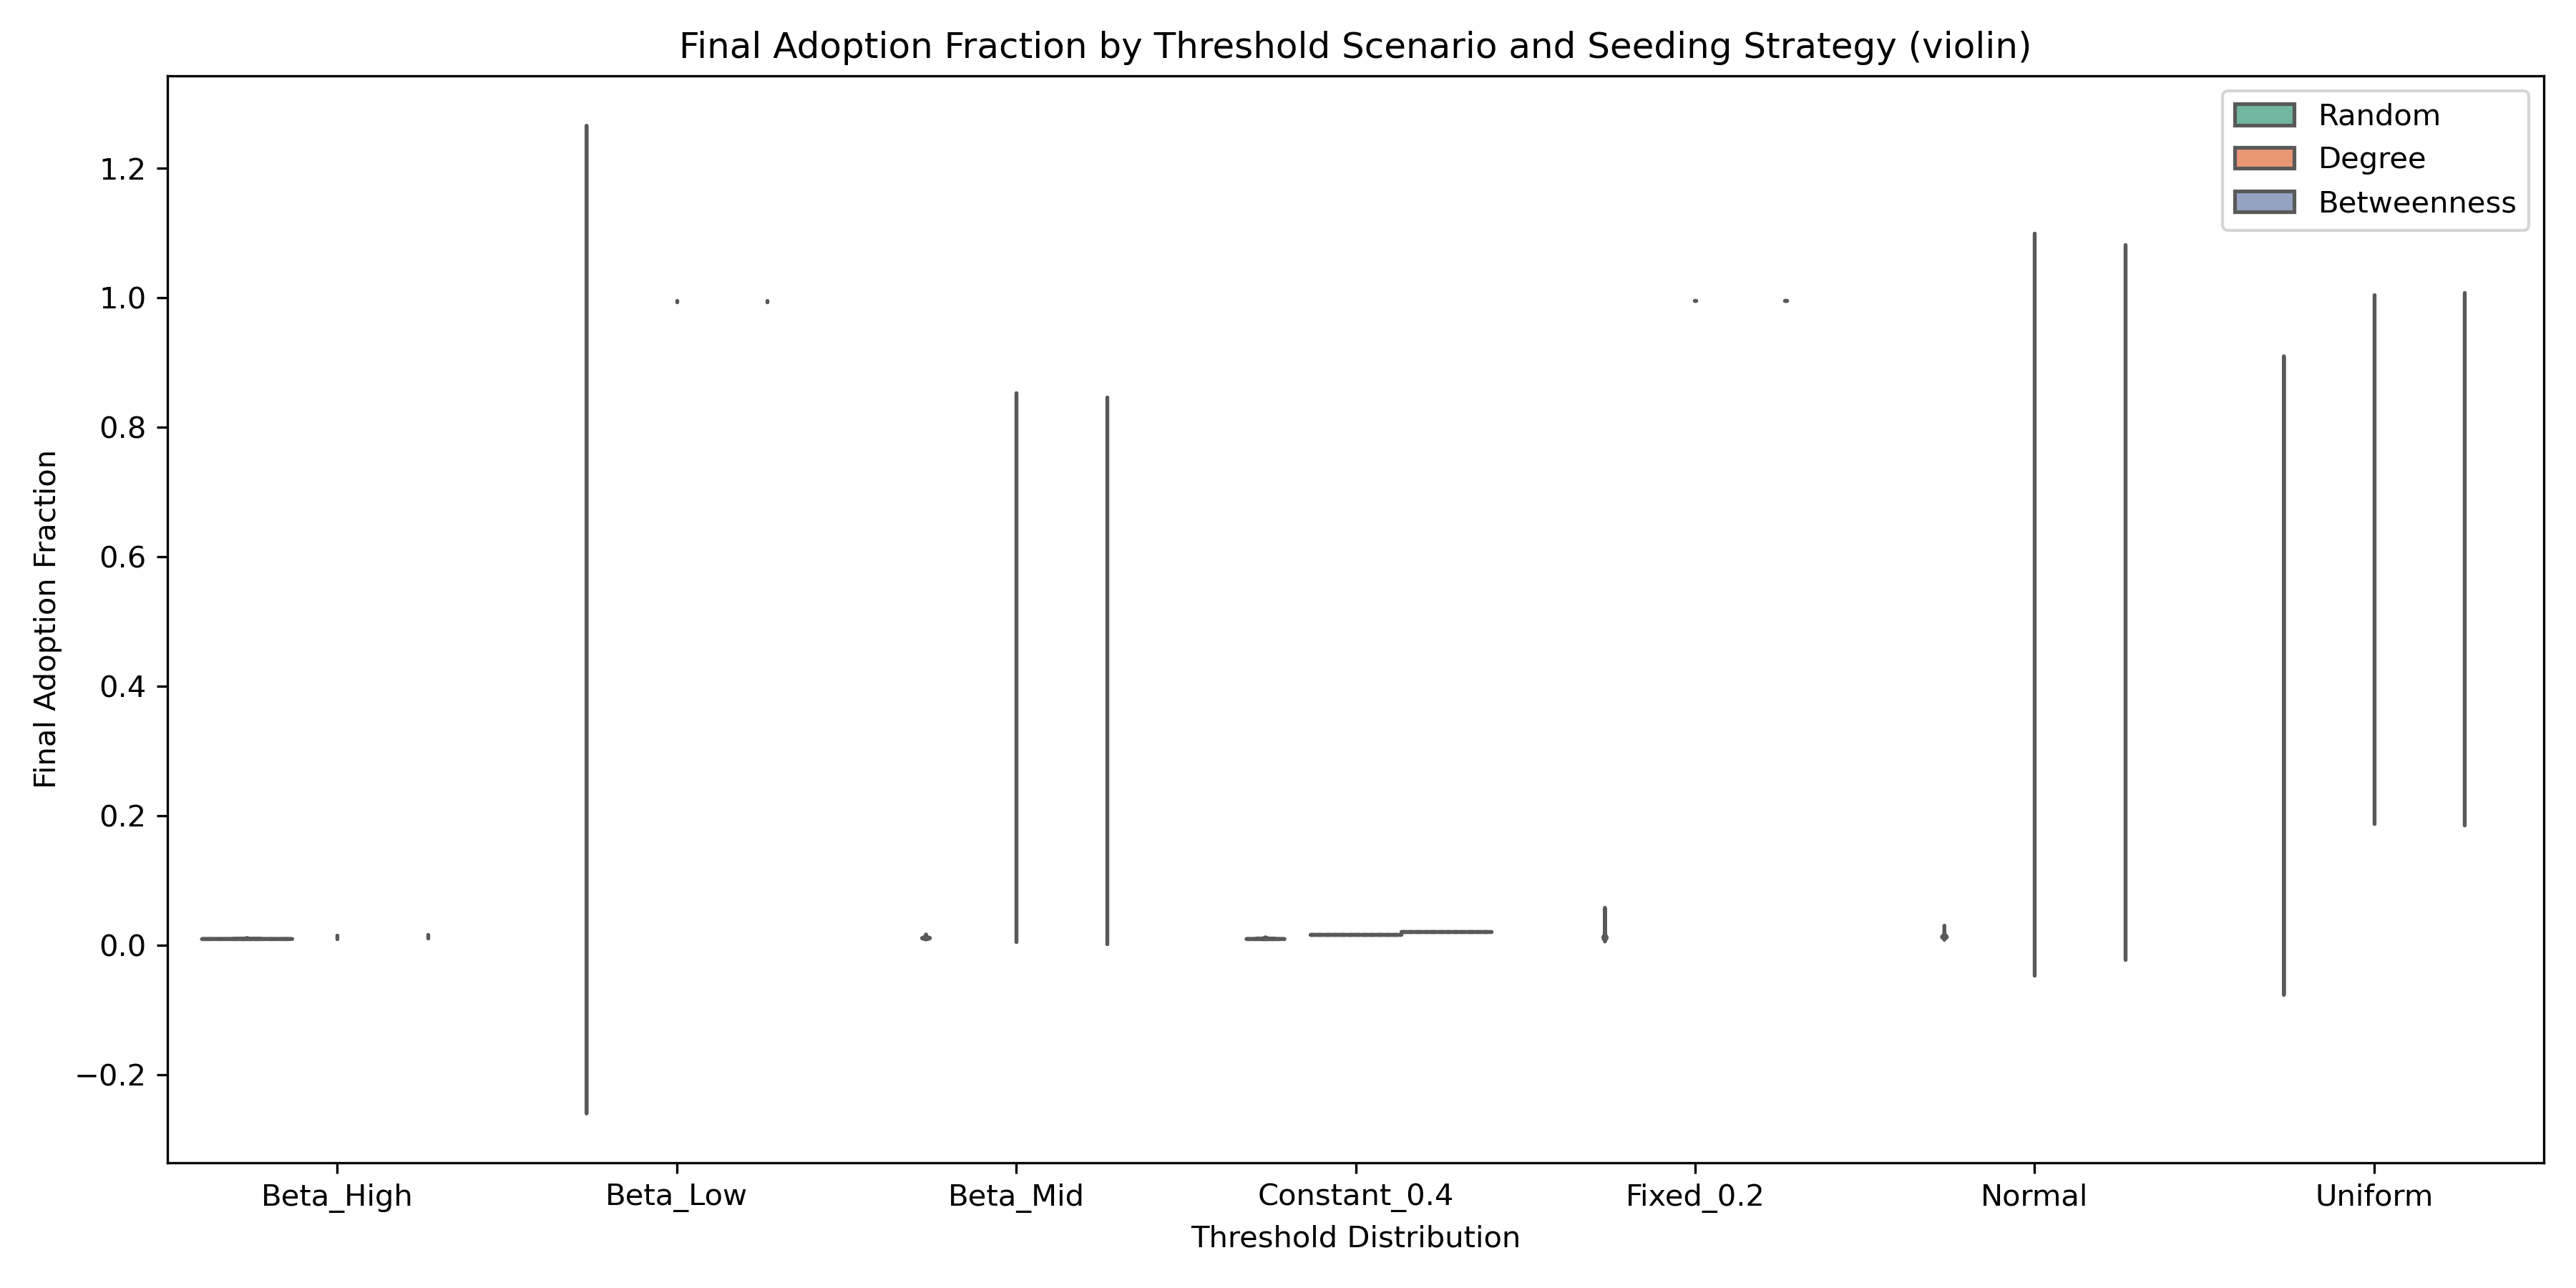

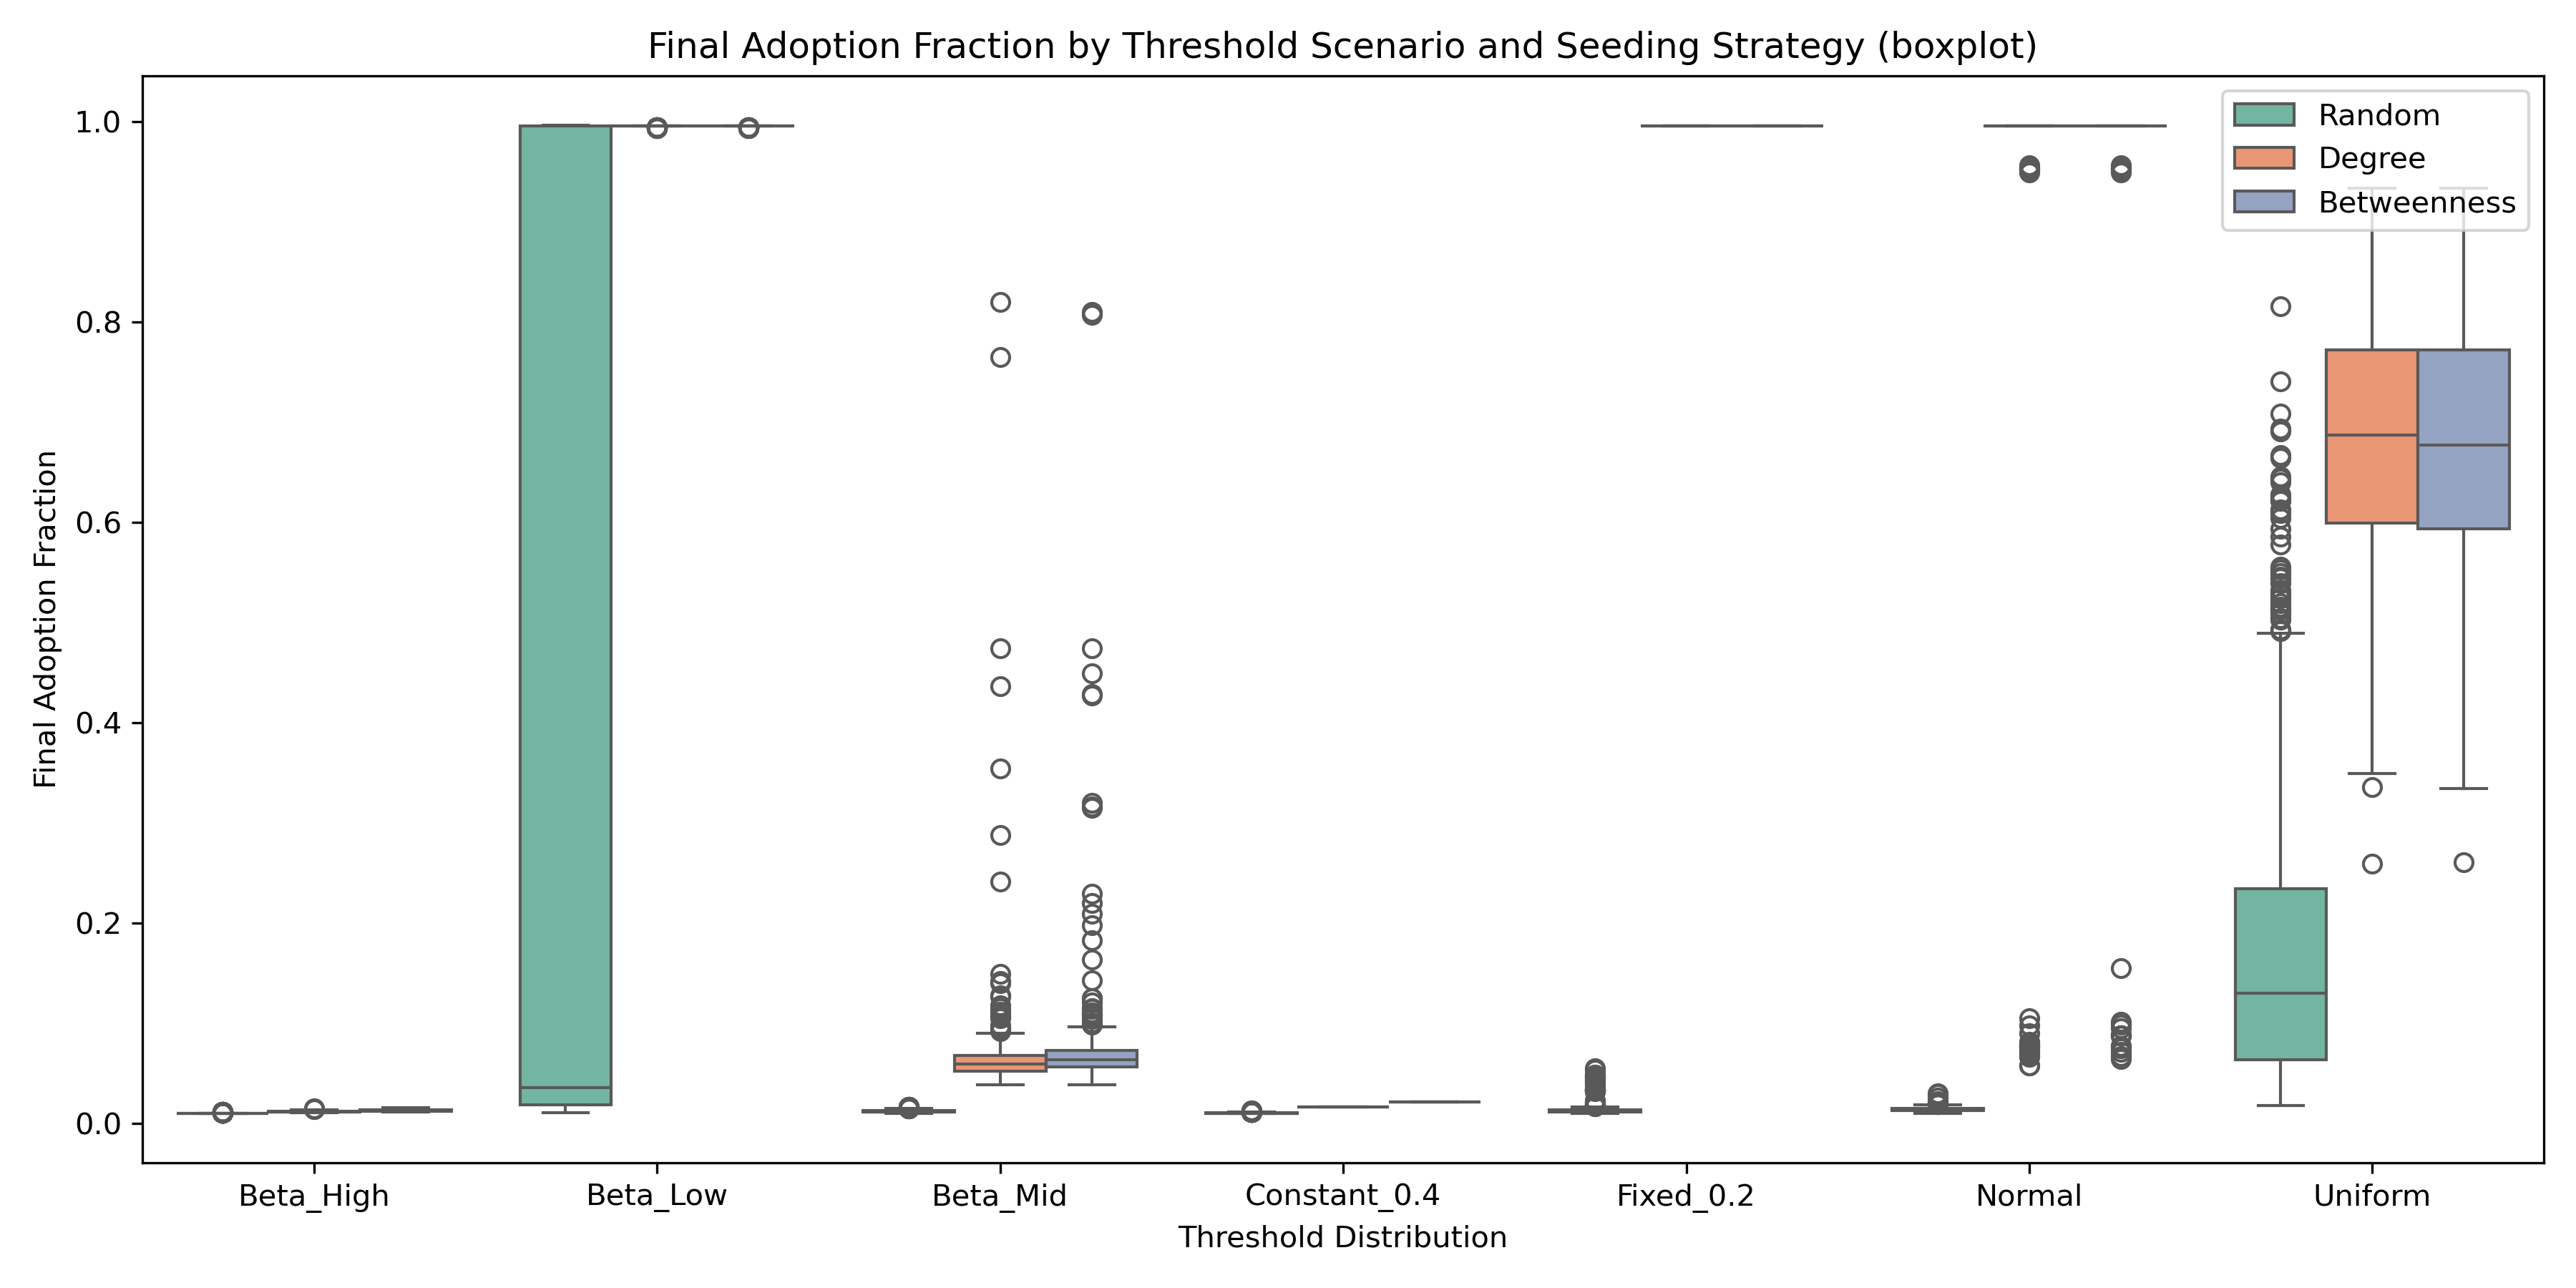

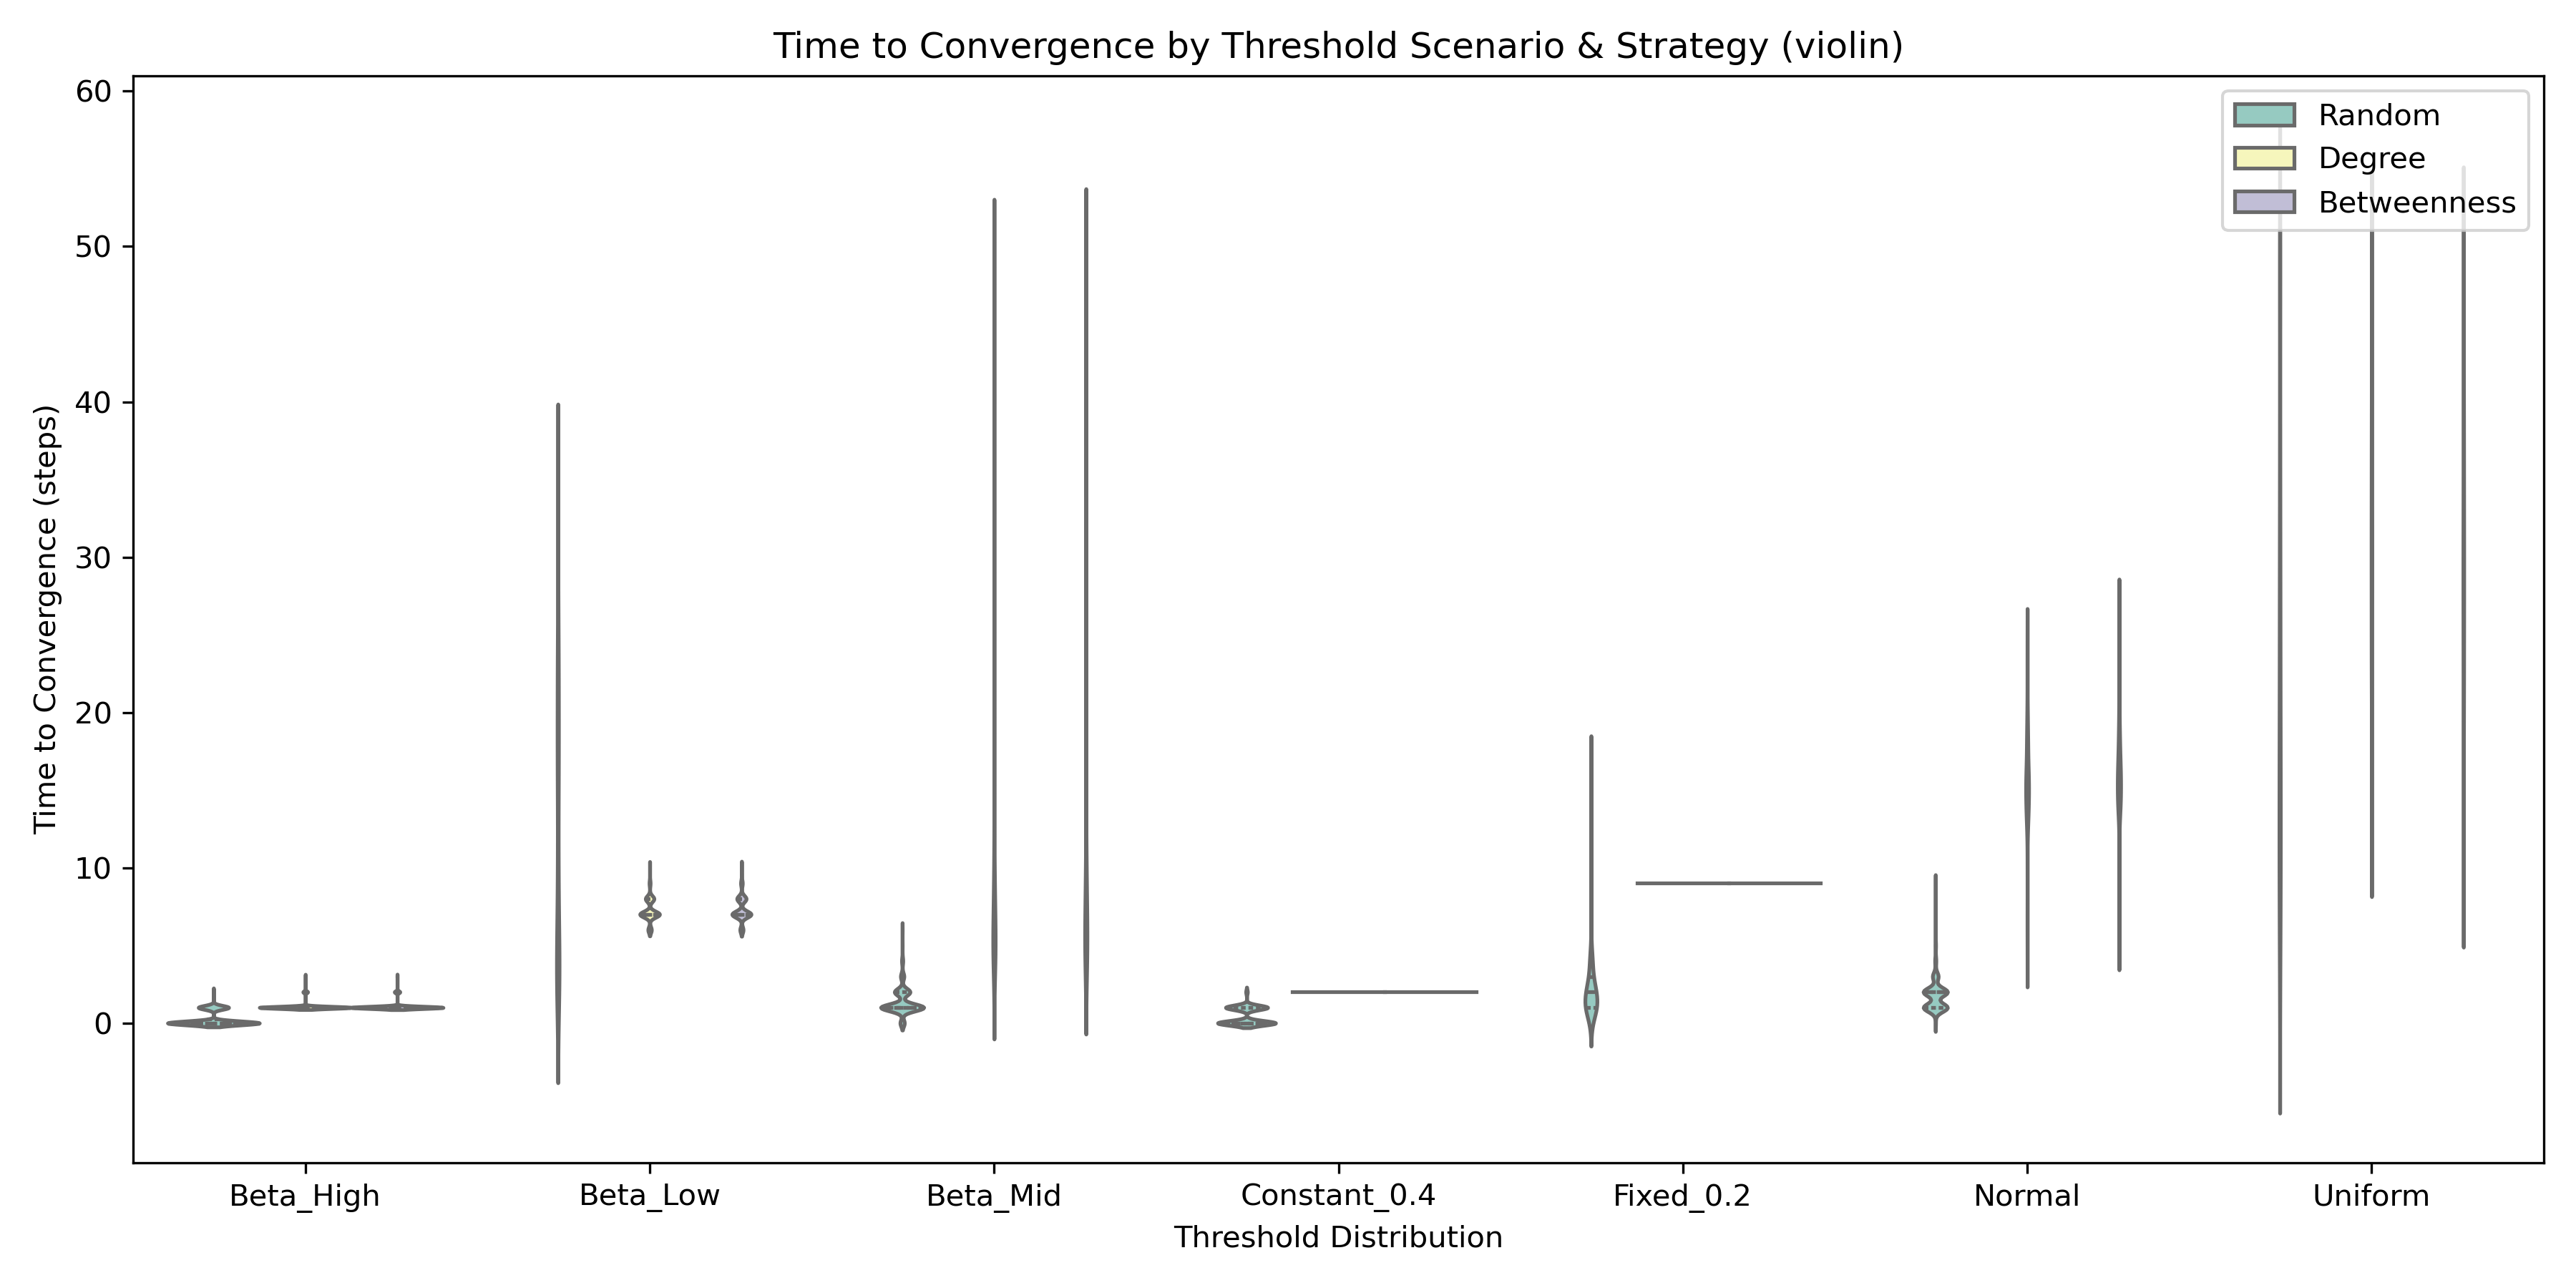

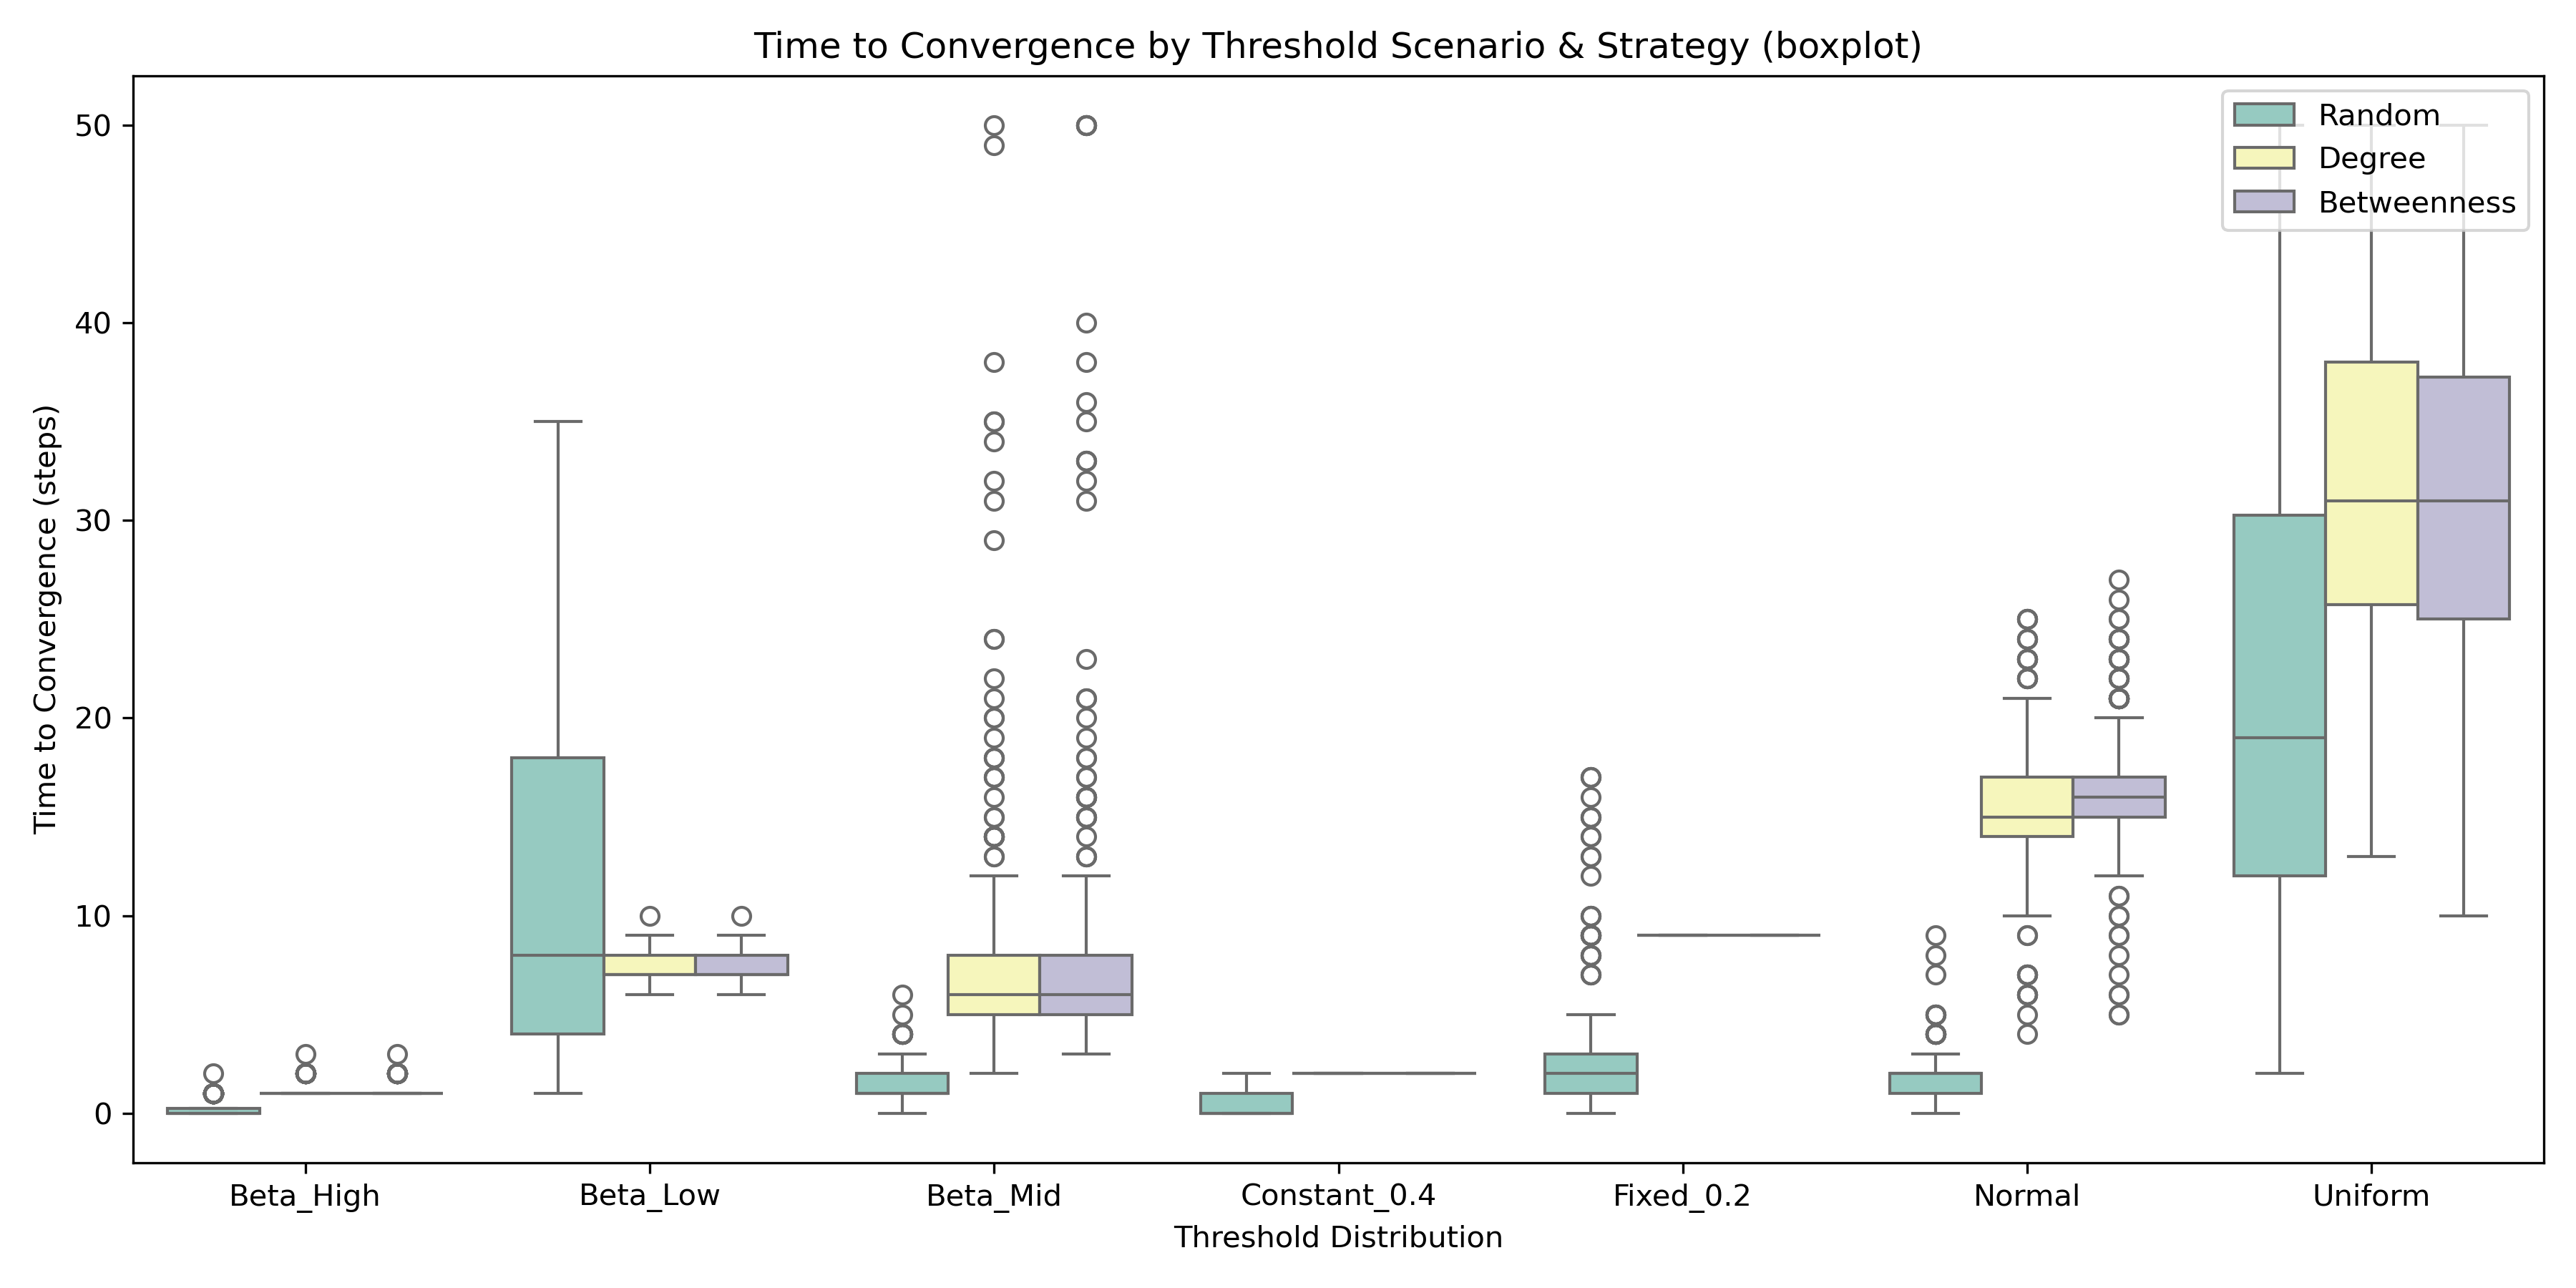

In [25]:
# Network / degree visuals
# Network / degree visuals
plot_degree_histogram(G_sample)                       # degree histogram (log-log by default)
plot_degree_ccdf(G_sample)                            # degree CCDF (log-log)

# Threshold distribution 
plot_thresholds_grid(df_results, G_sample, cols=3)

# Results / simulation diagnostics
plot_final_fraction_histogram(df_results, by='Strategy')     # violin by Strategy (or use by='Threshold_Dist')
plot_time_to_converge_histogram(df_results)                  # histogram of convergence times
plot_pivot_heatmap(df_results, value_col='Final_Fraction')   # heatmap Strategy x Threshold

# Node-level relationships
plot_degree_vs_betweenness(G_sample, bc_map)           # degree vs betweenness scatter

# Display the saved PNGs inline (useful when functions close figures after saving)
from IPython.display import Image, display
files_to_show = [
    os.path.join(OUTPUT_DIR, "degree_hist.png"),
    os.path.join(OUTPUT_DIR, "degree_ccdf.png"),
    os.path.join(OUTPUT_DIR, "threshold_hist.png"),
    os.path.join(OUTPUT_DIR, "final_frac_hist.png"),
    os.path.join(OUTPUT_DIR, "time_to_converge_hist.png"),
    os.path.join(OUTPUT_DIR, "pivot_heatmap.png"),
    os.path.join(OUTPUT_DIR, "deg_vs_bc.png"),
    os.path.join(OUTPUT_DIR, "network_topology.png"),
    os.path.join(OUTPUT_DIR, "adoption_curves_comparison_fixed.png"),
    os.path.join(OUTPUT_DIR, "violin_final_fraction.png"),
    os.path.join(OUTPUT_DIR, "boxplot_final_fraction.png"),
    os.path.join(OUTPUT_DIR, "violin_time_to_converge.png"),
    os.path.join(OUTPUT_DIR, "boxplot_time_to_converge.png"),
]

for p in files_to_show:
    if os.path.exists(p):
        display(Image(filename=p))
    else:
        print(f"[WARN] Missing file: {p}")